# Cypher- Neo4j

The following method of incorperating cypher code into pythod was found on "Towards Data Science" by Shuyi Yang.


In [47]:
pip install neo4j

In [244]:
from neo4j import __version__ as neo4j_version
print(neo4j_version)

4.4.2


In [245]:
from neo4j import GraphDatabase

Before starting please do the following:

- (create) and start a database in neo4j

- open the database and select the database information on the left side

- click on "Admin:server user add"

- create a user with the name "MDA", Password "MDA" and role "Admin"

You are now all set.


In [246]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

For the next line, make sure you have the same Local Host 

In [247]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="MDA", pwd="MDA")

In [248]:
conn.query("CREATE OR REPLACE DATABASE coradb")

[]

Making sure that there are no Nodes and Relationships in the Database

In [249]:
query_string = '''
MATCH(n) DETACH DELETE n
'''
conn.query(query_string, db='coradb')

[]

## Loading the Nodes and Relationships (based on Data from 2012-2015)

In [250]:
query_string = '''
CREATE (Belarus:Country {name:"Belarus", winner:"No"}),
(Romania:Country {name:"Romania", winner:"No"}),
(Malta:Country {name:"Malta", winner:"No"}),
(Switzerland:Country {name:"Switzerland", winner:"No"}),
(Estonia:Country {name:"Estonia", winner:"No"}),
(SanMarino:Country {name:"San Marino", winner:"No"}),
(Armenia:Country {name:"Armenia", winner:"No"}),
(Portugal:Country {name:"Portugal", winner:"No"}),
(Finland:Country {name:"Finland", winner:"No"}),
(Greece:Country {name:"Greece", winner:"No"}),
(UnitedKingdom:Country {name:"United Kingdom", winner:"No"}),
(Georgia:Country {name:"Georgia", winner:"No"}),
(Cyprus:Country {name:"Cyprus", winner:"No"}),
(Serbia:Country {name:"Serbia", winner:"No"}),
(Hungary:Country {name:"Hungary", winner:"No"}),
(Belgium:Country {name:"Belgium", winner:"No"}),
(Denmark:Country {name:"Denmark", winner:"Yes"}),
(Moldova:Country {name:"Moldova", winner:"No"}),
(Lithuania:Country {name:"Lithuania", winner:"No"}),
(Albania:Country {name:"Albania", winner:"No"}),
(Latvia:Country {name:"Latvia", winner:"No"}),
(CzechRepublic:Country {name:"CzechRepublic", winner:"No"}),
(BosniaHerzegovina:Country {name:"Bosnia Herzegovina", winner:"No"}),
(Russia:Country {name:"Russia", winner:"No"}),
(Sweden:Country {name:"Sweden", winner:"Yes"}),
(Ireland:Country {name:"Ireland", winner:"No"}),
(Turkey:Country {name:"Turkey", winner:"No"}),
(Azerbaijan:Country {name:"Azerbaijan", winner:"Yes"}),
(Israel:Country {name:"Israel", winner:"No"}),
(Slovenia:Country {name:"Slovenia", winner:"No"}),
(Austria:Country {name:"Austria", winner:"Yes"}),
(Poland:Country {name:"Poland", winner:"No"}),
(Australia:Country {name:"Australia", winner:"No"}),
(Macedonia:Country {name:"Macedonia", winner:"No"}),
(Iceland:Country {name:"Iceland", winner:"No"}),
(France:Country {name:"France", winner:"No"}),
(Italy:Country {name:"Italy", winner:"No"}),
(Spain:Country {name:"Spain", winner:"No"}),
(Montenegro:Country {name:"Montenegro", winner:"No"}),
(Germany:Country {name:"Germany", winner:"No"}),
(Ukraine:Country {name:"Ukraine", winner:"No"}),
(Bulgaria:Country {name:"Bulgaria", winner:"No"}),
(Croatia:Country {name:"Croatia", winner:"No"}),
(Netherlands:Country {name:"Netherlands", winner:"No"}),
(Slovakia:Country {name:"Slovakia", winner:"No"}),
(Norway:Country {name:"Norway", winner:"No"})

CREATE (Lithuania)-[:VOTE {year:2012,score:5 }]->(Serbia),
(Lithuania)-[:VOTE {year:2012,score:4 }]->(Italy),
(Lithuania)-[:VOTE {year:2012,score:2 }]->(Ukraine),
(Lithuania)-[:VOTE {year:2012,score:12 }]->(Azerbaijan),
(Lithuania)-[:VOTE {year:2012,score:3 }]->(Germany),
(Lithuania)-[:VOTE {year:2012,score:6 }]->(Russia),
(Lithuania)-[:VOTE {year:2012,score:1 }]->(Turkey),
(Lithuania)-[:VOTE {year:2012,score:10 }]->(Sweden),
(Lithuania)-[:VOTE {year:2012,score:7 }]->(Malta),
(Lithuania)-[:VOTE {year:2012,score:8 }]->(Estonia),
(Turkey)-[:VOTE {year:2012,score:3 }]->(Greece),
(Turkey)-[:VOTE {year:2012,score:4 }]->(Romania),
(Turkey)-[:VOTE {year:2012,score:12 }]->(Azerbaijan),
(Turkey)-[:VOTE {year:2012,score:8 }]->(Macedonia),
(Turkey)-[:VOTE {year:2012,score:7 }]->(Russia),
(Turkey)-[:VOTE {year:2012,score:6 }]->(Sweden),
(Turkey)-[:VOTE {year:2012,score:2 }]->(Malta),
(Turkey)-[:VOTE {year:2012,score:1 }]->(Hungary),
(Turkey)-[:VOTE {year:2012,score:10 }]->(BosniaHerzegovina),
(Turkey)-[:VOTE {year:2012,score:5 }]->(Albania),
(Denmark)-[:VOTE {year:2012,score:3 }]->(Italy),
(Denmark)-[:VOTE {year:2012,score:4 }]->(Ireland),
(Denmark)-[:VOTE {year:2012,score:5 }]->(Albania),
(Denmark)-[:VOTE {year:2012,score:6 }]->(Iceland),
(Denmark)-[:VOTE {year:2012,score:1 }]->(Romania),
(Denmark)-[:VOTE {year:2012,score:8 }]->(Russia),
(Denmark)-[:VOTE {year:2012,score:2 }]->(Turkey),
(Denmark)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Denmark)-[:VOTE {year:2012,score:10 }]->(Germany),
(Denmark)-[:VOTE {year:2012,score:7 }]->(Moldova),
(Albania)-[:VOTE {year:2012,score:1 }]->(Serbia),
(Albania)-[:VOTE {year:2012,score:8 }]->(Macedonia),
(Albania)-[:VOTE {year:2012,score:7 }]->(Italy),
(Albania)-[:VOTE {year:2012,score:4 }]->(Azerbaijan),
(Albania)-[:VOTE {year:2012,score:12 }]->(Greece),
(Albania)-[:VOTE {year:2012,score:3 }]->(Russia),
(Albania)-[:VOTE {year:2012,score:10 }]->(Turkey),
(Albania)-[:VOTE {year:2012,score:5 }]->(Sweden),
(Albania)-[:VOTE {year:2012,score:2 }]->(Germany),
(Albania)-[:VOTE {year:2012,score:6 }]->(Cyprus),
(Sweden)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Sweden)-[:VOTE {year:2012,score:4 }]->(Spain),
(Sweden)-[:VOTE {year:2012,score:5 }]->(Ireland),
(Sweden)-[:VOTE {year:2012,score:1 }]->(Albania),
(Sweden)-[:VOTE {year:2012,score:3 }]->(Norway),
(Sweden)-[:VOTE {year:2012,score:7 }]->(Russia),
(Sweden)-[:VOTE {year:2012,score:6 }]->(Turkey),
(Sweden)-[:VOTE {year:2012,score:2 }]->(France),
(Sweden)-[:VOTE {year:2012,score:12 }]->(Cyprus),
(Sweden)-[:VOTE {year:2012,score:8 }]->(Estonia),
(Slovenia)-[:VOTE {year:2012,score:12 }]->(Serbia),
(Slovenia)-[:VOTE {year:2012,score:5 }]->(Italy),
(Slovenia)-[:VOTE {year:2012,score:3 }]->(Albania),
(Slovenia)-[:VOTE {year:2012,score:4 }]->(Iceland),
(Slovenia)-[:VOTE {year:2012,score:6 }]->(Macedonia),
(Slovenia)-[:VOTE {year:2012,score:8 }]->(Russia),
(Slovenia)-[:VOTE {year:2012,score:10 }]->(Sweden),
(Slovenia)-[:VOTE {year:2012,score:2 }]->(Germany),
(Slovenia)-[:VOTE {year:2012,score:7 }]->(BosniaHerzegovina),
(Slovenia)-[:VOTE {year:2012,score:1 }]->(Moldova),
(Netherlands)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Netherlands)-[:VOTE {year:2012,score:6 }]->(Spain),
(Netherlands)-[:VOTE {year:2012,score:1 }]->(Lithuania),
(Netherlands)-[:VOTE {year:2012,score:5 }]->(Ireland),
(Netherlands)-[:VOTE {year:2012,score:3 }]->(Norway),
(Netherlands)-[:VOTE {year:2012,score:4 }]->(Russia),
(Netherlands)-[:VOTE {year:2012,score:8 }]->(Turkey),
(Netherlands)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Netherlands)-[:VOTE {year:2012,score:2 }]->(Germany),
(Netherlands)-[:VOTE {year:2012,score:7 }]->(Estonia),
(Switzerland)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Switzerland)-[:VOTE {year:2012,score:3 }]->(Turkey),
(Switzerland)-[:VOTE {year:2012,score:8 }]->(Spain),
(Switzerland)-[:VOTE {year:2012,score:12 }]->(Albania),
(Switzerland)-[:VOTE {year:2012,score:6 }]->(France),
(Switzerland)-[:VOTE {year:2012,score:7 }]->(Sweden),
(Switzerland)-[:VOTE {year:2012,score:4 }]->(Germany),
(Switzerland)-[:VOTE {year:2012,score:5 }]->(Italy),
(Switzerland)-[:VOTE {year:2012,score:1 }]->(BosniaHerzegovina),
(Switzerland)-[:VOTE {year:2012,score:2 }]->(Moldova),
(SanMarino)-[:VOTE {year:2012,score:6 }]->(Serbia),
(SanMarino)-[:VOTE {year:2012,score:7 }]->(Italy),
(SanMarino)-[:VOTE {year:2012,score:3 }]->(Sweden),
(SanMarino)-[:VOTE {year:2012,score:12 }]->(Albania),
(SanMarino)-[:VOTE {year:2012,score:10 }]->(Russia),
(SanMarino)-[:VOTE {year:2012,score:5 }]->(Turkey),
(SanMarino)-[:VOTE {year:2012,score:4 }]->(Azerbaijan),
(SanMarino)-[:VOTE {year:2012,score:2 }]->(Malta),
(SanMarino)-[:VOTE {year:2012,score:1 }]->(Spain),
(SanMarino)-[:VOTE {year:2012,score:8 }]->(Moldova),
(Estonia)-[:VOTE {year:2012,score:2 }]->(Denmark),
(Estonia)-[:VOTE {year:2012,score:7 }]->(Italy),
(Estonia)-[:VOTE {year:2012,score:3 }]->(Lithuania),
(Estonia)-[:VOTE {year:2012,score:6 }]->(Iceland),
(Estonia)-[:VOTE {year:2012,score:5 }]->(UnitedKingdom),
(Estonia)-[:VOTE {year:2012,score:8 }]->(Russia),
(Estonia)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Estonia)-[:VOTE {year:2012,score:10 }]->(Germany),
(Estonia)-[:VOTE {year:2012,score:4 }]->(Spain),
(Estonia)-[:VOTE {year:2012,score:1 }]->(Ukraine),
(Slovakia)-[:VOTE {year:2012,score:8 }]->(Hungary),
(Slovakia)-[:VOTE {year:2012,score:7 }]->(Serbia),
(Slovakia)-[:VOTE {year:2012,score:5 }]->(Italy),
(Slovakia)-[:VOTE {year:2012,score:6 }]->(Azerbaijan),
(Slovakia)-[:VOTE {year:2012,score:3 }]->(Russia),
(Slovakia)-[:VOTE {year:2012,score:1 }]->(Macedonia),
(Slovakia)-[:VOTE {year:2012,score:4 }]->(Iceland),
(Slovakia)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Slovakia)-[:VOTE {year:2012,score:2 }]->(BosniaHerzegovina),
(Slovakia)-[:VOTE {year:2012,score:10 }]->(Estonia),
(Finland)-[:VOTE {year:2012,score:2 }]->(Serbia),
(Finland)-[:VOTE {year:2012,score:3 }]->(Spain),
(Finland)-[:VOTE {year:2012,score:5 }]->(Denmark),
(Finland)-[:VOTE {year:2012,score:4 }]->(Ireland),
(Finland)-[:VOTE {year:2012,score:6 }]->(Albania),
(Finland)-[:VOTE {year:2012,score:7 }]->(Iceland),
(Finland)-[:VOTE {year:2012,score:8 }]->(Russia),
(Finland)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Finland)-[:VOTE {year:2012,score:1 }]->(Germany),
(Finland)-[:VOTE {year:2012,score:10 }]->(Estonia),
(Romania)-[:VOTE {year:2012,score:7 }]->(Hungary),
(Romania)-[:VOTE {year:2012,score:5 }]->(Serbia),
(Romania)-[:VOTE {year:2012,score:6 }]->(Spain),
(Romania)-[:VOTE {year:2012,score:1 }]->(Albania),
(Romania)-[:VOTE {year:2012,score:8 }]->(Greece),
(Romania)-[:VOTE {year:2012,score:4 }]->(Russia),
(Romania)-[:VOTE {year:2012,score:3 }]->(Turkey),
(Romania)-[:VOTE {year:2012,score:10 }]->(Sweden),
(Romania)-[:VOTE {year:2012,score:2 }]->(Cyprus),
(Romania)-[:VOTE {year:2012,score:12 }]->(Moldova),
(Ireland)-[:VOTE {year:2012,score:2 }]->(Italy),
(Ireland)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Ireland)-[:VOTE {year:2012,score:1 }]->(Azerbaijan),
(Ireland)-[:VOTE {year:2012,score:4 }]->(UnitedKingdom),
(Ireland)-[:VOTE {year:2012,score:5 }]->(Romania),
(Ireland)-[:VOTE {year:2012,score:6 }]->(Russia),
(Ireland)-[:VOTE {year:2012,score:7 }]->(Lithuania),
(Ireland)-[:VOTE {year:2012,score:10 }]->(Germany),
(Ireland)-[:VOTE {year:2012,score:3 }]->(Ukraine),
(Ireland)-[:VOTE {year:2012,score:8 }]->(Estonia),
(Portugal)-[:VOTE {year:2012,score:5 }]->(Serbia),
(Portugal)-[:VOTE {year:2012,score:12 }]->(Spain),
(Portugal)-[:VOTE {year:2012,score:3 }]->(Sweden),
(Portugal)-[:VOTE {year:2012,score:4 }]->(Romania),
(Portugal)-[:VOTE {year:2012,score:8 }]->(Russia),
(Portugal)-[:VOTE {year:2012,score:7 }]->(Estonia),
(Portugal)-[:VOTE {year:2012,score:10 }]->(Germany),
(Portugal)-[:VOTE {year:2012,score:2 }]->(Italy),
(Portugal)-[:VOTE {year:2012,score:1 }]->(Ukraine),
(Portugal)-[:VOTE {year:2012,score:6 }]->(Moldova),
(Belarus)-[:VOTE {year:2012,score:4 }]->(Estonia),
(Belarus)-[:VOTE {year:2012,score:8 }]->(Lithuania),
(Belarus)-[:VOTE {year:2012,score:1 }]->(Ireland),
(Belarus)-[:VOTE {year:2012,score:7 }]->(Azerbaijan),
(Belarus)-[:VOTE {year:2012,score:6 }]->(Sweden),
(Belarus)-[:VOTE {year:2012,score:2 }]->(Macedonia),
(Belarus)-[:VOTE {year:2012,score:12 }]->(Russia),
(Belarus)-[:VOTE {year:2012,score:10 }]->(Ukraine),
(Belarus)-[:VOTE {year:2012,score:3 }]->(Malta),
(Belarus)-[:VOTE {year:2012,score:5 }]->(Moldova),
(Cyprus)-[:VOTE {year:2012,score:7 }]->(Serbia),
(Cyprus)-[:VOTE {year:2012,score:3 }]->(Romania),
(Cyprus)-[:VOTE {year:2012,score:6 }]->(Spain),
(Cyprus)-[:VOTE {year:2012,score:8 }]->(Azerbaijan),
(Cyprus)-[:VOTE {year:2012,score:1 }]->(Iceland),
(Cyprus)-[:VOTE {year:2012,score:12 }]->(Greece),
(Cyprus)-[:VOTE {year:2012,score:5 }]->(Russia),
(Cyprus)-[:VOTE {year:2012,score:10 }]->(Sweden),
(Cyprus)-[:VOTE {year:2012,score:2 }]->(Italy),
(Cyprus)-[:VOTE {year:2012,score:4 }]->(Albania),
(Moldova)-[:VOTE {year:2012,score:3 }]->(Serbia),
(Moldova)-[:VOTE {year:2012,score:4 }]->(Greece),
(Moldova)-[:VOTE {year:2012,score:5 }]->(Italy),
(Moldova)-[:VOTE {year:2012,score:7 }]->(Sweden),
(Moldova)-[:VOTE {year:2012,score:10 }]->(Azerbaijan),
(Moldova)-[:VOTE {year:2012,score:12 }]->(Romania),
(Moldova)-[:VOTE {year:2012,score:6 }]->(Russia),
(Moldova)-[:VOTE {year:2012,score:8 }]->(Ukraine),
(Moldova)-[:VOTE {year:2012,score:1 }]->(Hungary),
(Moldova)-[:VOTE {year:2012,score:2 }]->(Estonia),
(Serbia)-[:VOTE {year:2012,score:2 }]->(Hungary),
(Serbia)-[:VOTE {year:2012,score:4 }]->(Greece),
(Serbia)-[:VOTE {year:2012,score:3 }]->(Azerbaijan),
(Serbia)-[:VOTE {year:2012,score:12 }]->(Macedonia),
(Serbia)-[:VOTE {year:2012,score:7 }]->(Russia),
(Serbia)-[:VOTE {year:2012,score:10 }]->(Sweden),
(Serbia)-[:VOTE {year:2012,score:6 }]->(Malta),
(Serbia)-[:VOTE {year:2012,score:8 }]->(Cyprus),
(Serbia)-[:VOTE {year:2012,score:5 }]->(BosniaHerzegovina),
(Serbia)-[:VOTE {year:2012,score:1 }]->(Albania),
(Montenegro)-[:VOTE {year:2012,score:12 }]->(Serbia),
(Montenegro)-[:VOTE {year:2012,score:2 }]->(Italy),
(Montenegro)-[:VOTE {year:2012,score:1 }]->(Lithuania),
(Montenegro)-[:VOTE {year:2012,score:10 }]->(Albania),
(Montenegro)-[:VOTE {year:2012,score:8 }]->(Macedonia),
(Montenegro)-[:VOTE {year:2012,score:4 }]->(Russia),
(Montenegro)-[:VOTE {year:2012,score:7 }]->(Sweden),
(Montenegro)-[:VOTE {year:2012,score:3 }]->(Moldova),
(Montenegro)-[:VOTE {year:2012,score:6 }]->(BosniaHerzegovina),
(Montenegro)-[:VOTE {year:2012,score:5 }]->(Azerbaijan),
(Bulgaria)-[:VOTE {year:2012,score:12 }]->(Serbia),
(Bulgaria)-[:VOTE {year:2012,score:1 }]->(Greece),
(Bulgaria)-[:VOTE {year:2012,score:3 }]->(Spain),
(Bulgaria)-[:VOTE {year:2012,score:5 }]->(Lithuania),
(Bulgaria)-[:VOTE {year:2012,score:10 }]->(Azerbaijan),
(Bulgaria)-[:VOTE {year:2012,score:2 }]->(Macedonia),
(Bulgaria)-[:VOTE {year:2012,score:6 }]->(Russia),
(Bulgaria)-[:VOTE {year:2012,score:7 }]->(Turkey),
(Bulgaria)-[:VOTE {year:2012,score:8 }]->(Sweden),
(Bulgaria)-[:VOTE {year:2012,score:4 }]->(Albania),
(Azerbaijan)-[:VOTE {year:2012,score:5 }]->(Greece),
(Azerbaijan)-[:VOTE {year:2012,score:4 }]->(Lithuania),
(Azerbaijan)-[:VOTE {year:2012,score:1 }]->(Ireland),
(Azerbaijan)-[:VOTE {year:2012,score:6 }]->(Romania),
(Azerbaijan)-[:VOTE {year:2012,score:10 }]->(Russia),
(Azerbaijan)-[:VOTE {year:2012,score:12 }]->(Turkey),
(Azerbaijan)-[:VOTE {year:2012,score:7 }]->(Sweden),
(Azerbaijan)-[:VOTE {year:2012,score:8 }]->(Malta),
(Azerbaijan)-[:VOTE {year:2012,score:3 }]->(Ukraine),
(Azerbaijan)-[:VOTE {year:2012,score:2 }]->(Cyprus),
(Norway)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Norway)-[:VOTE {year:2012,score:2 }]->(Denmark),
(Norway)-[:VOTE {year:2012,score:4 }]->(Italy),
(Norway)-[:VOTE {year:2012,score:6 }]->(Lithuania),
(Norway)-[:VOTE {year:2012,score:5 }]->(Iceland),
(Norway)-[:VOTE {year:2012,score:8 }]->(Russia),
(Norway)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Norway)-[:VOTE {year:2012,score:3 }]->(Germany),
(Norway)-[:VOTE {year:2012,score:1 }]->(Ukraine),
(Norway)-[:VOTE {year:2012,score:7 }]->(Estonia),
(UnitedKingdom)-[:VOTE {year:2012,score:8 }]->(Spain),
(UnitedKingdom)-[:VOTE {year:2012,score:12 }]->(Sweden),
(UnitedKingdom)-[:VOTE {year:2012,score:10 }]->(Ireland),
(UnitedKingdom)-[:VOTE {year:2012,score:2 }]->(Azerbaijan),
(UnitedKingdom)-[:VOTE {year:2012,score:3 }]->(Russia),
(UnitedKingdom)-[:VOTE {year:2012,score:5 }]->(Malta),
(UnitedKingdom)-[:VOTE {year:2012,score:1 }]->(Turkey),
(UnitedKingdom)-[:VOTE {year:2012,score:7 }]->(Lithuania),
(UnitedKingdom)-[:VOTE {year:2012,score:6 }]->(Germany),
(UnitedKingdom)-[:VOTE {year:2012,score:4 }]->(Estonia),
(Macedonia)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Macedonia)-[:VOTE {year:2012,score:5 }]->(Italy),
(Macedonia)-[:VOTE {year:2012,score:3 }]->(Ukraine),
(Macedonia)-[:VOTE {year:2012,score:12 }]->(Albania),
(Macedonia)-[:VOTE {year:2012,score:4 }]->(Russia),
(Macedonia)-[:VOTE {year:2012,score:8 }]->(Turkey),
(Macedonia)-[:VOTE {year:2012,score:6 }]->(Sweden),
(Macedonia)-[:VOTE {year:2012,score:1 }]->(Malta),
(Macedonia)-[:VOTE {year:2012,score:7 }]->(BosniaHerzegovina),
(Macedonia)-[:VOTE {year:2012,score:2 }]->(Azerbaijan),
(Iceland)-[:VOTE {year:2012,score:3 }]->(Serbia),
(Iceland)-[:VOTE {year:2012,score:2 }]->(Spain),
(Iceland)-[:VOTE {year:2012,score:5 }]->(Denmark),
(Iceland)-[:VOTE {year:2012,score:4 }]->(Ireland),
(Iceland)-[:VOTE {year:2012,score:1 }]->(Norway),
(Iceland)-[:VOTE {year:2012,score:7 }]->(Russia),
(Iceland)-[:VOTE {year:2012,score:6 }]->(France),
(Iceland)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Iceland)-[:VOTE {year:2012,score:8 }]->(Cyprus),
(Iceland)-[:VOTE {year:2012,score:10 }]->(Estonia),
(Israel)-[:VOTE {year:2012,score:2 }]->(Greece),
(Israel)-[:VOTE {year:2012,score:10 }]->(Spain),
(Israel)-[:VOTE {year:2012,score:3 }]->(Cyprus),
(Israel)-[:VOTE {year:2012,score:8 }]->(Azerbaijan),
(Israel)-[:VOTE {year:2012,score:6 }]->(Romania),
(Israel)-[:VOTE {year:2012,score:7 }]->(Russia),
(Israel)-[:VOTE {year:2012,score:1 }]->(Turkey),
(Israel)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Israel)-[:VOTE {year:2012,score:4 }]->(Italy),
(Israel)-[:VOTE {year:2012,score:5 }]->(Moldova),
(Belgium)-[:VOTE {year:2012,score:5 }]->(Serbia),
(Belgium)-[:VOTE {year:2012,score:2 }]->(Greece),
(Belgium)-[:VOTE {year:2012,score:6 }]->(Spain),
(Belgium)-[:VOTE {year:2012,score:4 }]->(Ireland),
(Belgium)-[:VOTE {year:2012,score:10 }]->(Albania),
(Belgium)-[:VOTE {year:2012,score:1 }]->(UnitedKingdom),
(Belgium)-[:VOTE {year:2012,score:3 }]->(Romania),
(Belgium)-[:VOTE {year:2012,score:8 }]->(Russia),
(Belgium)-[:VOTE {year:2012,score:7 }]->(Turkey),
(Belgium)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Germany)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Germany)-[:VOTE {year:2012,score:2 }]->(Italy),
(Germany)-[:VOTE {year:2012,score:5 }]->(Denmark),
(Germany)-[:VOTE {year:2012,score:6 }]->(Albania),
(Germany)-[:VOTE {year:2012,score:3 }]->(Iceland),
(Germany)-[:VOTE {year:2012,score:1 }]->(Greece),
(Germany)-[:VOTE {year:2012,score:7 }]->(Russia),
(Germany)-[:VOTE {year:2012,score:8 }]->(Turkey),
(Germany)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Germany)-[:VOTE {year:2012,score:4 }]->(Estonia),
(Croatia)-[:VOTE {year:2012,score:12 }]->(Serbia),
(Croatia)-[:VOTE {year:2012,score:2 }]->(Italy),
(Croatia)-[:VOTE {year:2012,score:3 }]->(Ireland),
(Croatia)-[:VOTE {year:2012,score:5 }]->(Albania),
(Croatia)-[:VOTE {year:2012,score:8 }]->(Macedonia),
(Croatia)-[:VOTE {year:2012,score:6 }]->(Russia),
(Croatia)-[:VOTE {year:2012,score:7 }]->(Sweden),
(Croatia)-[:VOTE {year:2012,score:4 }]->(Germany),
(Croatia)-[:VOTE {year:2012,score:10 }]->(BosniaHerzegovina),
(Croatia)-[:VOTE {year:2012,score:1 }]->(Moldova),
(Hungary)-[:VOTE {year:2012,score:4 }]->(Serbia),
(Hungary)-[:VOTE {year:2012,score:5 }]->(Italy),
(Hungary)-[:VOTE {year:2012,score:8 }]->(Albania),
(Hungary)-[:VOTE {year:2012,score:6 }]->(Iceland),
(Hungary)-[:VOTE {year:2012,score:2 }]->(Macedonia),
(Hungary)-[:VOTE {year:2012,score:7 }]->(Russia),
(Hungary)-[:VOTE {year:2012,score:3 }]->(Turkey),
(Hungary)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Hungary)-[:VOTE {year:2012,score:10 }]->(Germany),
(Hungary)-[:VOTE {year:2012,score:1 }]->(Spain),
(Georgia)-[:VOTE {year:2012,score:4 }]->(Italy),
(Georgia)-[:VOTE {year:2012,score:6 }]->(Ukraine),
(Georgia)-[:VOTE {year:2012,score:10 }]->(Azerbaijan),
(Georgia)-[:VOTE {year:2012,score:8 }]->(Sweden),
(Georgia)-[:VOTE {year:2012,score:1 }]->(Greece),
(Georgia)-[:VOTE {year:2012,score:5 }]->(Russia),
(Georgia)-[:VOTE {year:2012,score:7 }]->(Turkey),
(Georgia)-[:VOTE {year:2012,score:12 }]->(Lithuania),
(Georgia)-[:VOTE {year:2012,score:2 }]->(Germany),
(Georgia)-[:VOTE {year:2012,score:3 }]->(Albania),
(Italy)-[:VOTE {year:2012,score:6 }]->(Serbia),
(Italy)-[:VOTE {year:2012,score:1 }]->(Macedonia),
(Italy)-[:VOTE {year:2012,score:2 }]->(Denmark),
(Italy)-[:VOTE {year:2012,score:12 }]->(Albania),
(Italy)-[:VOTE {year:2012,score:7 }]->(Romania),
(Italy)-[:VOTE {year:2012,score:10 }]->(Russia),
(Italy)-[:VOTE {year:2012,score:3 }]->(Ukraine),
(Italy)-[:VOTE {year:2012,score:8 }]->(Germany),
(Italy)-[:VOTE {year:2012,score:5 }]->(Cyprus),
(Italy)-[:VOTE {year:2012,score:4 }]->(Moldova),
(Spain)-[:VOTE {year:2012,score:1 }]->(Italy),
(Spain)-[:VOTE {year:2012,score:2 }]->(Ukraine),
(Spain)-[:VOTE {year:2012,score:4 }]->(Iceland),
(Spain)-[:VOTE {year:2012,score:10 }]->(Romania),
(Spain)-[:VOTE {year:2012,score:8 }]->(Russia),
(Spain)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Spain)-[:VOTE {year:2012,score:3 }]->(Germany),
(Spain)-[:VOTE {year:2012,score:5 }]->(Cyprus),
(Spain)-[:VOTE {year:2012,score:7 }]->(Moldova),
(Spain)-[:VOTE {year:2012,score:6 }]->(Estonia),
(Latvia)-[:VOTE {year:2012,score:4 }]->(Lithuania),
(Latvia)-[:VOTE {year:2012,score:6 }]->(Ukraine),
(Latvia)-[:VOTE {year:2012,score:5 }]->(Ireland),
(Latvia)-[:VOTE {year:2012,score:1 }]->(Albania),
(Latvia)-[:VOTE {year:2012,score:2 }]->(UnitedKingdom),
(Latvia)-[:VOTE {year:2012,score:10 }]->(Russia),
(Latvia)-[:VOTE {year:2012,score:3 }]->(France),
(Latvia)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Latvia)-[:VOTE {year:2012,score:7 }]->(Germany),
(Latvia)-[:VOTE {year:2012,score:8 }]->(Estonia),
(Greece)-[:VOTE {year:2012,score:8 }]->(Serbia),
(Greece)-[:VOTE {year:2012,score:3 }]->(Italy),
(Greece)-[:VOTE {year:2012,score:1 }]->(Ukraine),
(Greece)-[:VOTE {year:2012,score:10 }]->(Albania),
(Greece)-[:VOTE {year:2012,score:7 }]->(Romania),
(Greece)-[:VOTE {year:2012,score:4 }]->(Russia),
(Greece)-[:VOTE {year:2012,score:6 }]->(Sweden),
(Greece)-[:VOTE {year:2012,score:12 }]->(Cyprus),
(Greece)-[:VOTE {year:2012,score:2 }]->(Moldova),
(Greece)-[:VOTE {year:2012,score:5 }]->(Azerbaijan),
(Russia)-[:VOTE {year:2012,score:4 }]->(Serbia),
(Russia)-[:VOTE {year:2012,score:5 }]->(Lithuania),
(Russia)-[:VOTE {year:2012,score:1 }]->(Romania),
(Russia)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Russia)-[:VOTE {year:2012,score:10 }]->(Azerbaijan),
(Russia)-[:VOTE {year:2012,score:3 }]->(Greece),
(Russia)-[:VOTE {year:2012,score:8 }]->(Ukraine),
(Russia)-[:VOTE {year:2012,score:2 }]->(Cyprus),
(Russia)-[:VOTE {year:2012,score:7 }]->(Moldova),
(Russia)-[:VOTE {year:2012,score:6 }]->(Estonia),
(France)-[:VOTE {year:2012,score:8 }]->(Serbia),
(France)-[:VOTE {year:2012,score:6 }]->(Spain),
(France)-[:VOTE {year:2012,score:3 }]->(Lithuania),
(France)-[:VOTE {year:2012,score:2 }]->(Romania),
(France)-[:VOTE {year:2012,score:4 }]->(Russia),
(France)-[:VOTE {year:2012,score:5 }]->(Turkey),
(France)-[:VOTE {year:2012,score:12 }]->(Sweden),
(France)-[:VOTE {year:2012,score:7 }]->(Germany),
(France)-[:VOTE {year:2012,score:1 }]->(Italy),
(France)-[:VOTE {year:2012,score:10 }]->(Estonia),
(Austria)-[:VOTE {year:2012,score:10 }]->(Serbia),
(Austria)-[:VOTE {year:2012,score:6 }]->(Spain),
(Austria)-[:VOTE {year:2012,score:8 }]->(Albania),
(Austria)-[:VOTE {year:2012,score:5 }]->(Russia),
(Austria)-[:VOTE {year:2012,score:3 }]->(Turkey),
(Austria)-[:VOTE {year:2012,score:12 }]->(Sweden),
(Austria)-[:VOTE {year:2012,score:4 }]->(Germany),
(Austria)-[:VOTE {year:2012,score:2 }]->(France),
(Austria)-[:VOTE {year:2012,score:7 }]->(BosniaHerzegovina),
(Austria)-[:VOTE {year:2012,score:1 }]->(Moldova),
(Malta)-[:VOTE {year:2012,score:5 }]->(Serbia),
(Malta)-[:VOTE {year:2012,score:4 }]->(Lithuania),
(Malta)-[:VOTE {year:2012,score:10 }]->(Italy),
(Malta)-[:VOTE {year:2012,score:6 }]->(Sweden),
(Malta)-[:VOTE {year:2012,score:12 }]->(Azerbaijan),
(Malta)-[:VOTE {year:2012,score:3 }]->(Russia),
(Malta)-[:VOTE {year:2012,score:8 }]->(Turkey),
(Malta)-[:VOTE {year:2012,score:7 }]->(Ukraine),
(Malta)-[:VOTE {year:2012,score:2 }]->(Germany),
(Malta)-[:VOTE {year:2012,score:1 }]->(Albania),
(Ukraine)-[:VOTE {year:2012,score:2 }]->(Serbia),
(Ukraine)-[:VOTE {year:2012,score:3 }]->(Macedonia),
(Ukraine)-[:VOTE {year:2012,score:4 }]->(Italy),
(Ukraine)-[:VOTE {year:2012,score:12 }]->(Azerbaijan),
(Ukraine)-[:VOTE {year:2012,score:5 }]->(Greece),
(Ukraine)-[:VOTE {year:2012,score:10 }]->(Russia),
(Ukraine)-[:VOTE {year:2012,score:6 }]->(Sweden),
(Ukraine)-[:VOTE {year:2012,score:7 }]->(Malta),
(Ukraine)-[:VOTE {year:2012,score:1 }]->(Estonia),
(Ukraine)-[:VOTE {year:2012,score:8 }]->(Moldova),
(BosniaHerzegovina)-[:VOTE {year:2012,score:10 }]->(Serbia),
(BosniaHerzegovina)-[:VOTE {year:2012,score:1 }]->(Greece),
(BosniaHerzegovina)-[:VOTE {year:2012,score:5 }]->(Spain),
(BosniaHerzegovina)-[:VOTE {year:2012,score:7 }]->(Azerbaijan),
(BosniaHerzegovina)-[:VOTE {year:2012,score:12 }]->(Macedonia),
(BosniaHerzegovina)-[:VOTE {year:2012,score:3 }]->(Russia),
(BosniaHerzegovina)-[:VOTE {year:2012,score:4 }]->(Turkey),
(BosniaHerzegovina)-[:VOTE {year:2012,score:8 }]->(Sweden),
(BosniaHerzegovina)-[:VOTE {year:2012,score:2 }]->(France),
(BosniaHerzegovina)-[:VOTE {year:2012,score:6 }]->(Albania),
(Lithuania)-[:VOTE {year:2013,score:5 }]->(Hungary),
(Lithuania)-[:VOTE {year:2013,score:8 }]->(Georgia),
(Lithuania)-[:VOTE {year:2013,score:1 }]->(Belarus),
(Lithuania)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Lithuania)-[:VOTE {year:2013,score:6 }]->(Norway),
(Lithuania)-[:VOTE {year:2013,score:7 }]->(Russia),
(Lithuania)-[:VOTE {year:2013,score:2 }]->(Denmark),
(Lithuania)-[:VOTE {year:2013,score:4 }]->(Netherlands),
(Lithuania)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Lithuania)-[:VOTE {year:2013,score:3 }]->(Estonia),
(Belgium)-[:VOTE {year:2013,score:6 }]->(Italy),
(Belgium)-[:VOTE {year:2013,score:8 }]->(Ukraine),
(Belgium)-[:VOTE {year:2013,score:5 }]->(Azerbaijan),
(Belgium)-[:VOTE {year:2013,score:7 }]->(Norway),
(Belgium)-[:VOTE {year:2013,score:1 }]->(UnitedKingdom),
(Belgium)-[:VOTE {year:2013,score:2 }]->(Greece),
(Belgium)-[:VOTE {year:2013,score:4 }]->(Russia),
(Belgium)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Belgium)-[:VOTE {year:2013,score:12 }]->(Netherlands),
(Belgium)-[:VOTE {year:2013,score:3 }]->(Moldova),
(Bulgaria)-[:VOTE {year:2013,score:6 }]->(Hungary),
(Bulgaria)-[:VOTE {year:2013,score:4 }]->(Sweden),
(Bulgaria)-[:VOTE {year:2013,score:8 }]->(Armenia),
(Bulgaria)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Bulgaria)-[:VOTE {year:2013,score:1 }]->(Norway),
(Bulgaria)-[:VOTE {year:2013,score:7 }]->(Greece),
(Bulgaria)-[:VOTE {year:2013,score:5 }]->(Russia),
(Bulgaria)-[:VOTE {year:2013,score:2 }]->(Denmark),
(Bulgaria)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Bulgaria)-[:VOTE {year:2013,score:3 }]->(Moldova),
(Albania)-[:VOTE {year:2013,score:8 }]->(Hungary),
(Albania)-[:VOTE {year:2013,score:5 }]->(Romania),
(Albania)-[:VOTE {year:2013,score:12 }]->(Italy),
(Albania)-[:VOTE {year:2013,score:7 }]->(Azerbaijan),
(Albania)-[:VOTE {year:2013,score:2 }]->(Norway),
(Albania)-[:VOTE {year:2013,score:10 }]->(Greece),
(Albania)-[:VOTE {year:2013,score:4 }]->(Netherlands),
(Albania)-[:VOTE {year:2013,score:1 }]->(Denmark),
(Albania)-[:VOTE {year:2013,score:3 }]->(Germany),
(Albania)-[:VOTE {year:2013,score:6 }]->(Spain),
(Sweden)-[:VOTE {year:2013,score:3 }]->(Hungary),
(Sweden)-[:VOTE {year:2013,score:7 }]->(Belgium),
(Sweden)-[:VOTE {year:2013,score:2 }]->(Ireland),
(Sweden)-[:VOTE {year:2013,score:1 }]->(UnitedKingdom),
(Sweden)-[:VOTE {year:2013,score:12 }]->(Norway),
(Sweden)-[:VOTE {year:2013,score:5 }]->(Russia),
(Sweden)-[:VOTE {year:2013,score:4 }]->(Romania),
(Sweden)-[:VOTE {year:2013,score:6 }]->(Iceland),
(Sweden)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Sweden)-[:VOTE {year:2013,score:8 }]->(Netherlands),
(Slovenia)-[:VOTE {year:2013,score:8 }]->(Italy),
(Slovenia)-[:VOTE {year:2013,score:2 }]->(Belgium),
(Slovenia)-[:VOTE {year:2013,score:3 }]->(Azerbaijan),
(Slovenia)-[:VOTE {year:2013,score:5 }]->(Norway),
(Slovenia)-[:VOTE {year:2013,score:10 }]->(Russia),
(Slovenia)-[:VOTE {year:2013,score:1 }]->(UnitedKingdom),
(Slovenia)-[:VOTE {year:2013,score:4 }]->(Iceland),
(Slovenia)-[:VOTE {year:2013,score:12 }]->(Denmark),
(Slovenia)-[:VOTE {year:2013,score:7 }]->(Netherlands),
(Slovenia)-[:VOTE {year:2013,score:6 }]->(Sweden),
(Netherlands)-[:VOTE {year:2013,score:7 }]->(Hungary),
(Netherlands)-[:VOTE {year:2013,score:12 }]->(Belgium),
(Netherlands)-[:VOTE {year:2013,score:2 }]->(Azerbaijan),
(Netherlands)-[:VOTE {year:2013,score:6 }]->(Norway),
(Netherlands)-[:VOTE {year:2013,score:3 }]->(Sweden),
(Netherlands)-[:VOTE {year:2013,score:1 }]->(Greece),
(Netherlands)-[:VOTE {year:2013,score:8 }]->(Russia),
(Netherlands)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Netherlands)-[:VOTE {year:2013,score:8 }]->(Malta),
(Netherlands)-[:VOTE {year:2013,score:5 }]->(Ukraine),
(SanMarino)-[:VOTE {year:2013,score:6 }]->(Hungary),
(SanMarino)-[:VOTE {year:2013,score:4 }]->(Italy),
(SanMarino)-[:VOTE {year:2013,score:1 }]->(Armenia),
(SanMarino)-[:VOTE {year:2013,score:2 }]->(Azerbaijan),
(SanMarino)-[:VOTE {year:2013,score:7 }]->(Norway),
(SanMarino)-[:VOTE {year:2013,score:3 }]->(Finland),
(SanMarino)-[:VOTE {year:2013,score:12 }]->(Greece),
(SanMarino)-[:VOTE {year:2013,score:8 }]->(France),
(SanMarino)-[:VOTE {year:2013,score:5 }]->(Belgium),
(SanMarino)-[:VOTE {year:2013,score:10 }]->(Malta),
(Estonia)-[:VOTE {year:2013,score:4 }]->(Hungary),
(Estonia)-[:VOTE {year:2013,score:7 }]->(Netherlands),
(Estonia)-[:VOTE {year:2013,score:3 }]->(Italy),
(Estonia)-[:VOTE {year:2013,score:2 }]->(Belgium),
(Estonia)-[:VOTE {year:2013,score:1 }]->(Sweden),
(Estonia)-[:VOTE {year:2013,score:12 }]->(Russia),
(Estonia)-[:VOTE {year:2013,score:6 }]->(Iceland),
(Estonia)-[:VOTE {year:2013,score:8 }]->(Denmark),
(Estonia)-[:VOTE {year:2013,score:5 }]->(Malta),
(Estonia)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Spain)-[:VOTE {year:2013,score:12 }]->(Italy),
(Spain)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Spain)-[:VOTE {year:2013,score:7 }]->(Azerbaijan),
(Spain)-[:VOTE {year:2013,score:5 }]->(Norway),
(Spain)-[:VOTE {year:2013,score:6 }]->(Russia),
(Spain)-[:VOTE {year:2013,score:4 }]->(UnitedKingdom),
(Spain)-[:VOTE {year:2013,score:3 }]->(Germany),
(Spain)-[:VOTE {year:2013,score:8 }]->(Denmark),
(Spain)-[:VOTE {year:2013,score:1 }]->(Malta),
(Spain)-[:VOTE {year:2013,score:2 }]->(Moldova),
(Finland)-[:VOTE {year:2013,score:10 }]->(Hungary),
(Finland)-[:VOTE {year:2013,score:3 }]->(Belgium),
(Finland)-[:VOTE {year:2013,score:4 }]->(Sweden),
(Finland)-[:VOTE {year:2013,score:12 }]->(Norway),
(Finland)-[:VOTE {year:2013,score:2 }]->(Russia),
(Finland)-[:VOTE {year:2013,score:1 }]->(Greece),
(Finland)-[:VOTE {year:2013,score:5 }]->(Iceland),
(Finland)-[:VOTE {year:2013,score:7 }]->(Denmark),
(Finland)-[:VOTE {year:2013,score:8 }]->(Netherlands),
(Finland)-[:VOTE {year:2013,score:6 }]->(Estonia),
(Romania)-[:VOTE {year:2013,score:1 }]->(Italy),
(Romania)-[:VOTE {year:2013,score:4 }]->(Ukraine),
(Romania)-[:VOTE {year:2013,score:10 }]->(Azerbaijan),
(Romania)-[:VOTE {year:2013,score:8 }]->(Norway),
(Romania)-[:VOTE {year:2013,score:3 }]->(UnitedKingdom),
(Romania)-[:VOTE {year:2013,score:7 }]->(Greece),
(Romania)-[:VOTE {year:2013,score:2 }]->(Netherlands),
(Romania)-[:VOTE {year:2013,score:6 }]->(Denmark),
(Romania)-[:VOTE {year:2013,score:5 }]->(Malta),
(Romania)-[:VOTE {year:2013,score:12 }]->(Moldova),
(Ireland)-[:VOTE {year:2013,score:8 }]->(Ukraine),
(Ireland)-[:VOTE {year:2013,score:1 }]->(Lithuania),
(Ireland)-[:VOTE {year:2013,score:2 }]->(Azerbaijan),
(Ireland)-[:VOTE {year:2013,score:5 }]->(Sweden),
(Ireland)-[:VOTE {year:2013,score:7 }]->(UnitedKingdom),
(Ireland)-[:VOTE {year:2013,score:10 }]->(Russia),
(Ireland)-[:VOTE {year:2013,score:12 }]->(Denmark),
(Ireland)-[:VOTE {year:2013,score:6 }]->(Netherlands),
(Ireland)-[:VOTE {year:2013,score:4 }]->(Belgium),
(Ireland)-[:VOTE {year:2013,score:3 }]->(Moldova),
(Belarus)-[:VOTE {year:2013,score:1 }]->(Denmark),
(Belarus)-[:VOTE {year:2013,score:2 }]->(Armenia),
(Belarus)-[:VOTE {year:2013,score:10 }]->(Azerbaijan),
(Belarus)-[:VOTE {year:2013,score:3 }]->(Norway),
(Belarus)-[:VOTE {year:2013,score:6 }]->(Greece),
(Belarus)-[:VOTE {year:2013,score:8 }]->(Russia),
(Belarus)-[:VOTE {year:2013,score:5 }]->(Lithuania),
(Belarus)-[:VOTE {year:2013,score:7 }]->(Malta),
(Belarus)-[:VOTE {year:2013,score:12 }]->(Ukraine),
(Belarus)-[:VOTE {year:2013,score:4 }]->(Moldova),
(Cyprus)-[:VOTE {year:2013,score:6 }]->(Italy),
(Cyprus)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Cyprus)-[:VOTE {year:2013,score:2 }]->(Ireland),
(Cyprus)-[:VOTE {year:2013,score:8 }]->(Azerbaijan),
(Cyprus)-[:VOTE {year:2013,score:4 }]->(Norway),
(Cyprus)-[:VOTE {year:2013,score:12 }]->(Greece),
(Cyprus)-[:VOTE {year:2013,score:5 }]->(Russia),
(Cyprus)-[:VOTE {year:2013,score:1 }]->(France),
(Cyprus)-[:VOTE {year:2013,score:7 }]->(Denmark),
(Cyprus)-[:VOTE {year:2013,score:3 }]->(Malta),
(Moldova)-[:VOTE {year:2013,score:3 }]->(Georgia),
(Moldova)-[:VOTE {year:2013,score:4 }]->(Belarus),
(Moldova)-[:VOTE {year:2013,score:1 }]->(Armenia),
(Moldova)-[:VOTE {year:2013,score:8 }]->(Azerbaijan),
(Moldova)-[:VOTE {year:2013,score:2 }]->(Norway),
(Moldova)-[:VOTE {year:2013,score:5 }]->(Sweden),
(Moldova)-[:VOTE {year:2013,score:10 }]->(Romania),
(Moldova)-[:VOTE {year:2013,score:7 }]->(Russia),
(Moldova)-[:VOTE {year:2013,score:6 }]->(Denmark),
(Moldova)-[:VOTE {year:2013,score:12 }]->(Ukraine),
(Serbia)-[:VOTE {year:2013,score:2 }]->(Hungary),
(Serbia)-[:VOTE {year:2013,score:4 }]->(Italy),
(Serbia)-[:VOTE {year:2013,score:3 }]->(Belgium),
(Serbia)-[:VOTE {year:2013,score:5 }]->(Azerbaijan),
(Serbia)-[:VOTE {year:2013,score:7 }]->(Norway),
(Serbia)-[:VOTE {year:2013,score:1 }]->(Sweden),
(Serbia)-[:VOTE {year:2013,score:8 }]->(Russia),
(Serbia)-[:VOTE {year:2013,score:12 }]->(Denmark),
(Serbia)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Serbia)-[:VOTE {year:2013,score:6 }]->(Moldova),
(Montenegro)-[:VOTE {year:2013,score:2 }]->(Georgia),
(Montenegro)-[:VOTE {year:2013,score:6 }]->(Italy),
(Montenegro)-[:VOTE {year:2013,score:3 }]->(Belarus),
(Montenegro)-[:VOTE {year:2013,score:1 }]->(Romania),
(Montenegro)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Montenegro)-[:VOTE {year:2013,score:4 }]->(Norway),
(Montenegro)-[:VOTE {year:2013,score:8 }]->(Greece),
(Montenegro)-[:VOTE {year:2013,score:7 }]->(Russia),
(Montenegro)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Montenegro)-[:VOTE {year:2013,score:5 }]->(Moldova),
(Armenia)-[:VOTE {year:2013,score:10 }]->(Georgia),
(Armenia)-[:VOTE {year:2013,score:1 }]->(Italy),
(Armenia)-[:VOTE {year:2013,score:5 }]->(Belarus),
(Armenia)-[:VOTE {year:2013,score:3 }]->(Norway),
(Armenia)-[:VOTE {year:2013,score:8 }]->(Greece),
(Armenia)-[:VOTE {year:2013,score:7 }]->(Russia),
(Armenia)-[:VOTE {year:2013,score:2 }]->(France),
(Armenia)-[:VOTE {year:2013,score:4 }]->(Denmark),
(Armenia)-[:VOTE {year:2013,score:6 }]->(Malta),
(Armenia)-[:VOTE {year:2013,score:12 }]->(Ukraine),
(Azerbaijan)-[:VOTE {year:2013,score:3 }]->(Lithuania),
(Azerbaijan)-[:VOTE {year:2013,score:6 }]->(Romania),
(Azerbaijan)-[:VOTE {year:2013,score:7 }]->(Belarus),
(Azerbaijan)-[:VOTE {year:2013,score:2 }]->(Norway),
(Azerbaijan)-[:VOTE {year:2013,score:10 }]->(Georgia),
(Azerbaijan)-[:VOTE {year:2013,score:4 }]->(Greece),
(Azerbaijan)-[:VOTE {year:2013,score:5 }]->(Denmark),
(Azerbaijan)-[:VOTE {year:2013,score:8 }]->(Malta),
(Azerbaijan)-[:VOTE {year:2013,score:12 }]->(Ukraine),
(Azerbaijan)-[:VOTE {year:2013,score:1 }]->(Moldova),
(Norway)-[:VOTE {year:2013,score:2 }]->(Hungary),
(Norway)-[:VOTE {year:2013,score:6 }]->(Romania),
(Norway)-[:VOTE {year:2013,score:3 }]->(Belgium),
(Norway)-[:VOTE {year:2013,score:12 }]->(Sweden),
(Norway)-[:VOTE {year:2013,score:5 }]->(Greece),
(Norway)-[:VOTE {year:2013,score:4 }]->(Iceland),
(Norway)-[:VOTE {year:2013,score:8 }]->(Netherlands),
(Norway)-[:VOTE {year:2013,score:7 }]->(Denmark),
(Norway)-[:VOTE {year:2013,score:10 }]->(Malta),
(Norway)-[:VOTE {year:2013,score:1 }]->(Ukraine),
(UnitedKingdom)-[:VOTE {year:2013,score:4 }]->(Romania),
(UnitedKingdom)-[:VOTE {year:2013,score:3 }]->(Belgium),
(UnitedKingdom)-[:VOTE {year:2013,score:1 }]->(Ireland),
(UnitedKingdom)-[:VOTE {year:2013,score:10 }]->(Russia),
(UnitedKingdom)-[:VOTE {year:2013,score:8 }]->(Greece),
(UnitedKingdom)-[:VOTE {year:2013,score:2 }]->(Iceland),
(UnitedKingdom)-[:VOTE {year:2013,score:6 }]->(Netherlands),
(UnitedKingdom)-[:VOTE {year:2013,score:12 }]->(Denmark),
(UnitedKingdom)-[:VOTE {year:2013,score:7 }]->(Malta),
(UnitedKingdom)-[:VOTE {year:2013,score:5 }]->(Ukraine),
(Macedonia)-[:VOTE {year:2013,score:2 }]->(Netherlands),
(Macedonia)-[:VOTE {year:2013,score:10 }]->(Italy),
(Macedonia)-[:VOTE {year:2013,score:5 }]->(Belarus),
(Macedonia)-[:VOTE {year:2013,score:8 }]->(Norway),
(Macedonia)-[:VOTE {year:2013,score:4 }]->(Greece),
(Macedonia)-[:VOTE {year:2013,score:6 }]->(Russia),
(Macedonia)-[:VOTE {year:2013,score:1 }]->(France),
(Macedonia)-[:VOTE {year:2013,score:12 }]->(Denmark),
(Macedonia)-[:VOTE {year:2013,score:3 }]->(Malta),
(Macedonia)-[:VOTE {year:2013,score:7 }]->(Moldova),
(Iceland)-[:VOTE {year:2013,score:8 }]->(Netherlands),
(Iceland)-[:VOTE {year:2013,score:4 }]->(Sweden),
(Iceland)-[:VOTE {year:2013,score:7 }]->(Azerbaijan),
(Iceland)-[:VOTE {year:2013,score:10 }]->(Norway),
(Iceland)-[:VOTE {year:2013,score:6 }]->(Romania),
(Iceland)-[:VOTE {year:2013,score:1 }]->(Russia),
(Iceland)-[:VOTE {year:2013,score:2 }]->(France),
(Iceland)-[:VOTE {year:2013,score:12 }]->(Denmark),
(Iceland)-[:VOTE {year:2013,score:5 }]->(Malta),
(Iceland)-[:VOTE {year:2013,score:3 }]->(Ukraine),
(Israel)-[:VOTE {year:2013,score:3 }]->(Belarus),
(Israel)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Israel)-[:VOTE {year:2013,score:6 }]->(Norway),
(Israel)-[:VOTE {year:2013,score:4 }]->(Finland),
(Israel)-[:VOTE {year:2013,score:2 }]->(Greece),
(Israel)-[:VOTE {year:2013,score:7 }]->(Russia),
(Israel)-[:VOTE {year:2013,score:8 }]->(Denmark),
(Israel)-[:VOTE {year:2013,score:5 }]->(Germany),
(Israel)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Israel)-[:VOTE {year:2013,score:1 }]->(Moldova),
(Denmark)-[:VOTE {year:2013,score:10 }]->(Netherlands),
(Denmark)-[:VOTE {year:2013,score:7 }]->(Russia),
(Denmark)-[:VOTE {year:2013,score:8 }]->(Sweden),
(Denmark)-[:VOTE {year:2013,score:12 }]->(Norway),
(Denmark)-[:VOTE {year:2013,score:2 }]->(Finland),
(Denmark)-[:VOTE {year:2013,score:6 }]->(Greece),
(Denmark)-[:VOTE {year:2013,score:1 }]->(Iceland),
(Denmark)-[:VOTE {year:2013,score:5 }]->(Belgium),
(Denmark)-[:VOTE {year:2013,score:4 }]->(Malta),
(Denmark)-[:VOTE {year:2013,score:3 }]->(Ukraine),
(Germany)-[:VOTE {year:2013,score:12 }]->(Hungary),
(Germany)-[:VOTE {year:2013,score:2 }]->(Russia),
(Germany)-[:VOTE {year:2013,score:4 }]->(Azerbaijan),
(Germany)-[:VOTE {year:2013,score:7 }]->(Norway),
(Germany)-[:VOTE {year:2013,score:1 }]->(Finland),
(Germany)-[:VOTE {year:2013,score:6 }]->(Greece),
(Germany)-[:VOTE {year:2013,score:8 }]->(Iceland),
(Germany)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Germany)-[:VOTE {year:2013,score:5 }]->(Malta),
(Germany)-[:VOTE {year:2013,score:3 }]->(Sweden),
(Croatia)-[:VOTE {year:2013,score:4 }]->(Hungary),
(Croatia)-[:VOTE {year:2013,score:8 }]->(Italy),
(Croatia)-[:VOTE {year:2013,score:1 }]->(Sweden),
(Croatia)-[:VOTE {year:2013,score:7 }]->(Azerbaijan),
(Croatia)-[:VOTE {year:2013,score:3 }]->(Norway),
(Croatia)-[:VOTE {year:2013,score:5 }]->(Greece),
(Croatia)-[:VOTE {year:2013,score:6 }]->(Russia),
(Croatia)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Croatia)-[:VOTE {year:2013,score:2 }]->(Netherlands),
(Croatia)-[:VOTE {year:2013,score:12 }]->(Ukraine),
(Hungary)-[:VOTE {year:2013,score:5 }]->(Netherlands),
(Hungary)-[:VOTE {year:2013,score:4 }]->(Belgium),
(Hungary)-[:VOTE {year:2013,score:3 }]->(Armenia),
(Hungary)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Hungary)-[:VOTE {year:2013,score:2 }]->(Norway),
(Hungary)-[:VOTE {year:2013,score:1 }]->(Greece),
(Hungary)-[:VOTE {year:2013,score:6 }]->(Iceland),
(Hungary)-[:VOTE {year:2013,score:10 }]->(Denmark),
(Hungary)-[:VOTE {year:2013,score:8 }]->(Malta),
(Hungary)-[:VOTE {year:2013,score:7 }]->(Ukraine),
(Georgia)-[:VOTE {year:2013,score:1 }]->(Lithuania),
(Georgia)-[:VOTE {year:2013,score:2 }]->(Italy),
(Georgia)-[:VOTE {year:2013,score:5 }]->(Belarus),
(Georgia)-[:VOTE {year:2013,score:10 }]->(Armenia),
(Georgia)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Georgia)-[:VOTE {year:2013,score:4 }]->(Norway),
(Georgia)-[:VOTE {year:2013,score:6 }]->(Russia),
(Georgia)-[:VOTE {year:2013,score:7 }]->(Denmark),
(Georgia)-[:VOTE {year:2013,score:3 }]->(Malta),
(Georgia)-[:VOTE {year:2013,score:8 }]->(Ukraine),
(Italy)-[:VOTE {year:2013,score:3 }]->(Hungary),
(Italy)-[:VOTE {year:2013,score:1 }]->(Romania),
(Italy)-[:VOTE {year:2013,score:2 }]->(Spain),
(Italy)-[:VOTE {year:2013,score:6 }]->(Lithuania),
(Italy)-[:VOTE {year:2013,score:8 }]->(Norway),
(Italy)-[:VOTE {year:2013,score:7 }]->(Greece),
(Italy)-[:VOTE {year:2013,score:12 }]->(Denmark),
(Italy)-[:VOTE {year:2013,score:10 }]->(Malta),
(Italy)-[:VOTE {year:2013,score:5 }]->(Ukraine),
(Italy)-[:VOTE {year:2013,score:4 }]->(Moldova),
(Switzerland)-[:VOTE {year:2013,score:10 }]->(Hungary),
(Switzerland)-[:VOTE {year:2013,score:4 }]->(Netherlands),
(Switzerland)-[:VOTE {year:2013,score:12 }]->(Italy),
(Switzerland)-[:VOTE {year:2013,score:6 }]->(Azerbaijan),
(Switzerland)-[:VOTE {year:2013,score:7 }]->(Norway),
(Switzerland)-[:VOTE {year:2013,score:2 }]->(UnitedKingdom),
(Switzerland)-[:VOTE {year:2013,score:8 }]->(Greece),
(Switzerland)-[:VOTE {year:2013,score:5 }]->(Iceland),
(Switzerland)-[:VOTE {year:2013,score:3 }]->(Denmark),
(Switzerland)-[:VOTE {year:2013,score:1 }]->(Germany),
(Greece)-[:VOTE {year:2013,score:2 }]->(Hungary),
(Greece)-[:VOTE {year:2013,score:5 }]->(Georgia),
(Greece)-[:VOTE {year:2013,score:6 }]->(Italy),
(Greece)-[:VOTE {year:2013,score:1 }]->(Belarus),
(Greece)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Greece)-[:VOTE {year:2013,score:4 }]->(Norway),
(Greece)-[:VOTE {year:2013,score:10 }]->(Romania),
(Greece)-[:VOTE {year:2013,score:7 }]->(Denmark),
(Greece)-[:VOTE {year:2013,score:3 }]->(Malta),
(Greece)-[:VOTE {year:2013,score:8 }]->(Ukraine),
(Russia)-[:VOTE {year:2013,score:5 }]->(Georgia),
(Russia)-[:VOTE {year:2013,score:8 }]->(Belgium),
(Russia)-[:VOTE {year:2013,score:2 }]->(Armenia),
(Russia)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Russia)-[:VOTE {year:2013,score:7 }]->(Norway),
(Russia)-[:VOTE {year:2013,score:10 }]->(Greece),
(Russia)-[:VOTE {year:2013,score:4 }]->(Denmark),
(Russia)-[:VOTE {year:2013,score:3 }]->(Netherlands),
(Russia)-[:VOTE {year:2013,score:1 }]->(Ukraine),
(Russia)-[:VOTE {year:2013,score:6 }]->(Moldova),
(France)-[:VOTE {year:2013,score:10 }]->(Italy),
(France)-[:VOTE {year:2013,score:5 }]->(Belgium),
(France)-[:VOTE {year:2013,score:7 }]->(Armenia),
(France)-[:VOTE {year:2013,score:8 }]->(Azerbaijan),
(France)-[:VOTE {year:2013,score:3 }]->(Finland),
(France)-[:VOTE {year:2013,score:1 }]->(Romania),
(France)-[:VOTE {year:2013,score:6 }]->(Russia),
(France)-[:VOTE {year:2013,score:12 }]->(Denmark),
(France)-[:VOTE {year:2013,score:2 }]->(Malta),
(France)-[:VOTE {year:2013,score:4 }]->(Moldova),
(Austria)-[:VOTE {year:2013,score:4 }]->(Romania),
(Austria)-[:VOTE {year:2013,score:10 }]->(Italy),
(Austria)-[:VOTE {year:2013,score:3 }]->(Belgium),
(Austria)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Austria)-[:VOTE {year:2013,score:7 }]->(Greece),
(Austria)-[:VOTE {year:2013,score:8 }]->(Netherlands),
(Austria)-[:VOTE {year:2013,score:5 }]->(Denmark),
(Austria)-[:VOTE {year:2013,score:6 }]->(Germany),
(Austria)-[:VOTE {year:2013,score:1 }]->(Ukraine),
(Austria)-[:VOTE {year:2013,score:2 }]->(Moldova),
(Malta)-[:VOTE {year:2013,score:7 }]->(Romania),
(Malta)-[:VOTE {year:2013,score:8 }]->(Italy),
(Malta)-[:VOTE {year:2013,score:2 }]->(Belarus),
(Malta)-[:VOTE {year:2013,score:1 }]->(Armenia),
(Malta)-[:VOTE {year:2013,score:12 }]->(Azerbaijan),
(Malta)-[:VOTE {year:2013,score:3 }]->(Norway),
(Malta)-[:VOTE {year:2013,score:4 }]->(Greece),
(Malta)-[:VOTE {year:2013,score:5 }]->(UnitedKingdom),
(Malta)-[:VOTE {year:2013,score:6 }]->(Denmark),
(Malta)-[:VOTE {year:2013,score:10 }]->(Ukraine),
(Ukraine)-[:VOTE {year:2013,score:7 }]->(Georgia),
(Ukraine)-[:VOTE {year:2013,score:12 }]->(Belarus),
(Ukraine)-[:VOTE {year:2013,score:6 }]->(Armenia),
(Ukraine)-[:VOTE {year:2013,score:10 }]->(Azerbaijan),
(Ukraine)-[:VOTE {year:2013,score:3 }]->(Norway),
(Ukraine)-[:VOTE {year:2013,score:4 }]->(Russia),
(Ukraine)-[:VOTE {year:2013,score:1 }]->(Lithuania),
(Ukraine)-[:VOTE {year:2013,score:5 }]->(Denmark),
(Ukraine)-[:VOTE {year:2013,score:2 }]->(Malta),
(Ukraine)-[:VOTE {year:2013,score:8 }]->(Moldova),
(Latvia)-[:VOTE {year:2013,score:2 }]->(Belgium),
(Latvia)-[:VOTE {year:2013,score:3 }]->(Azerbaijan),
(Latvia)-[:VOTE {year:2013,score:8 }]->(Norway),
(Latvia)-[:VOTE {year:2013,score:4 }]->(Sweden),
(Latvia)-[:VOTE {year:2013,score:1 }]->(Greece),
(Latvia)-[:VOTE {year:2013,score:12 }]->(Russia),
(Latvia)-[:VOTE {year:2013,score:6 }]->(Denmark),
(Latvia)-[:VOTE {year:2013,score:5 }]->(Malta),
(Latvia)-[:VOTE {year:2013,score:7 }]->(Ukraine),
(Latvia)-[:VOTE {year:2013,score:10 }]->(Estonia),
(Lithuania)-[:VOTE {year:2014,score:1 }]->(Denmark),
(Lithuania)-[:VOTE {year:2014,score:4 }]->(Spain),
(Lithuania)-[:VOTE {year:2014,score:5 }]->(Ukraine),
(Lithuania)-[:VOTE {year:2014,score:2 }]->(Switzerland),
(Lithuania)-[:VOTE {year:2014,score:8 }]->(Norway),
(Lithuania)-[:VOTE {year:2014,score:7 }]->(Sweden),
(Lithuania)-[:VOTE {year:2014,score:6 }]->(Russia),
(Lithuania)-[:VOTE {year:2014,score:10 }]->(Austria),
(Lithuania)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Lithuania)-[:VOTE {year:2014,score:3 }]->(Belarus),
(Belgium)-[:VOTE {year:2014,score:7 }]->(Hungary),
(Belgium)-[:VOTE {year:2014,score:2 }]->(Spain),
(Belgium)-[:VOTE {year:2014,score:4 }]->(Ukraine),
(Belgium)-[:VOTE {year:2014,score:1 }]->(UnitedKingdom),
(Belgium)-[:VOTE {year:2014,score:10 }]->(Sweden),
(Belgium)-[:VOTE {year:2014,score:3 }]->(Finland),
(Belgium)-[:VOTE {year:2014,score:5 }]->(Romania),
(Belgium)-[:VOTE {year:2014,score:6 }]->(Denmark),
(Belgium)-[:VOTE {year:2014,score:12 }]->(Austria),
(Belgium)-[:VOTE {year:2014,score:8 }]->(Netherlands),
(Albania)-[:VOTE {year:2014,score:8 }]->(Hungary),
(Albania)-[:VOTE {year:2014,score:1 }]->(Malta),
(Albania)-[:VOTE {year:2014,score:6 }]->(Montenegro),
(Albania)-[:VOTE {year:2014,score:7 }]->(Sweden),
(Albania)-[:VOTE {year:2014,score:3 }]->(SanMarino),
(Albania)-[:VOTE {year:2014,score:2 }]->(Greece),
(Albania)-[:VOTE {year:2014,score:12 }]->(Spain),
(Albania)-[:VOTE {year:2014,score:5 }]->(Austria),
(Albania)-[:VOTE {year:2014,score:4 }]->(Germany),
(Albania)-[:VOTE {year:2014,score:10 }]->(Italy),
(Sweden)-[:VOTE {year:2014,score:7 }]->(Hungary),
(Sweden)-[:VOTE {year:2014,score:8 }]->(Denmark),
(Sweden)-[:VOTE {year:2014,score:2 }]->(Poland),
(Sweden)-[:VOTE {year:2014,score:5 }]->(Armenia),
(Sweden)-[:VOTE {year:2014,score:3 }]->(Norway),
(Sweden)-[:VOTE {year:2014,score:6 }]->(Finland),
(Sweden)-[:VOTE {year:2014,score:4 }]->(Iceland),
(Sweden)-[:VOTE {year:2014,score:1 }]->(France),
(Sweden)-[:VOTE {year:2014,score:12 }]->(Austria),
(Sweden)-[:VOTE {year:2014,score:10 }]->(Netherlands),
(Slovenia)-[:VOTE {year:2014,score:3 }]->(Hungary),
(Slovenia)-[:VOTE {year:2014,score:6 }]->(Denmark),
(Slovenia)-[:VOTE {year:2014,score:7 }]->(Montenegro),
(Slovenia)-[:VOTE {year:2014,score:1 }]->(Poland),
(Slovenia)-[:VOTE {year:2014,score:5 }]->(Norway),
(Slovenia)-[:VOTE {year:2014,score:8 }]->(Sweden),
(Slovenia)-[:VOTE {year:2014,score:10 }]->(Netherlands),
(Slovenia)-[:VOTE {year:2014,score:12 }]->(Austria),
(Slovenia)-[:VOTE {year:2014,score:2 }]->(Germany),
(Slovenia)-[:VOTE {year:2014,score:4 }]->(Spain),
(Netherlands)-[:VOTE {year:2014,score:4 }]->(Hungary),
(Netherlands)-[:VOTE {year:2014,score:1 }]->(Denmark),
(Netherlands)-[:VOTE {year:2014,score:8 }]->(Sweden),
(Netherlands)-[:VOTE {year:2014,score:7 }]->(Armenia),
(Netherlands)-[:VOTE {year:2014,score:10 }]->(Norway),
(Netherlands)-[:VOTE {year:2014,score:2 }]->(Finland),
(Netherlands)-[:VOTE {year:2014,score:4 }]->(Iceland),
(Netherlands)-[:VOTE {year:2014,score:12 }]->(Austria),
(Netherlands)-[:VOTE {year:2014,score:5 }]->(Malta),
(Netherlands)-[:VOTE {year:2014,score:3 }]->(Switzerland),
(SanMarino)-[:VOTE {year:2014,score:7 }]->(Hungary),
(SanMarino)-[:VOTE {year:2014,score:2 }]->(Netherlands),
(SanMarino)-[:VOTE {year:2014,score:1 }]->(Denmark),
(SanMarino)-[:VOTE {year:2014,score:6 }]->(Armenia),
(SanMarino)-[:VOTE {year:2014,score:12 }]->(Azerbaijan),
(SanMarino)-[:VOTE {year:2014,score:3 }]->(Finland),
(SanMarino)-[:VOTE {year:2014,score:5 }]->(UnitedKingdom),
(SanMarino)-[:VOTE {year:2014,score:8 }]->(Iceland),
(SanMarino)-[:VOTE {year:2014,score:10 }]->(Sweden),
(SanMarino)-[:VOTE {year:2014,score:4 }]->(Malta),
(Estonia)-[:VOTE {year:2014,score:7 }]->(Hungary),
(Estonia)-[:VOTE {year:2014,score:2 }]->(Spain),
(Estonia)-[:VOTE {year:2014,score:8 }]->(Ukraine),
(Estonia)-[:VOTE {year:2014,score:5 }]->(Armenia),
(Estonia)-[:VOTE {year:2014,score:3 }]->(Norway),
(Estonia)-[:VOTE {year:2014,score:10 }]->(Sweden),
(Estonia)-[:VOTE {year:2014,score:1 }]->(Russia),
(Estonia)-[:VOTE {year:2014,score:6 }]->(Finland),
(Estonia)-[:VOTE {year:2014,score:4 }]->(Austria),
(Estonia)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Spain)-[:VOTE {year:2014,score:2 }]->(Hungary),
(Spain)-[:VOTE {year:2014,score:3 }]->(Denmark),
(Spain)-[:VOTE {year:2014,score:12 }]->(Austria),
(Spain)-[:VOTE {year:2014,score:4 }]->(Armenia),
(Spain)-[:VOTE {year:2014,score:5 }]->(UnitedKingdom),
(Spain)-[:VOTE {year:2014,score:10 }]->(Sweden),
(Spain)-[:VOTE {year:2014,score:8 }]->(Romania),
(Spain)-[:VOTE {year:2014,score:1 }]->(Iceland),
(Spain)-[:VOTE {year:2014,score:6 }]->(Ukraine),
(Spain)-[:VOTE {year:2014,score:7 }]->(Netherlands),
(Finland)-[:VOTE {year:2014,score:5 }]->(Hungary),
(Finland)-[:VOTE {year:2014,score:6 }]->(Denmark),
(Finland)-[:VOTE {year:2014,score:2 }]->(Ukraine),
(Finland)-[:VOTE {year:2014,score:4 }]->(Armenia),
(Finland)-[:VOTE {year:2014,score:7 }]->(Norway),
(Finland)-[:VOTE {year:2014,score:10 }]->(Sweden),
(Finland)-[:VOTE {year:2014,score:8 }]->(Netherlands),
(Finland)-[:VOTE {year:2014,score:1 }]->(France),
(Finland)-[:VOTE {year:2014,score:12 }]->(Austria),
(Finland)-[:VOTE {year:2014,score:3 }]->(Malta),
(Romania)-[:VOTE {year:2014,score:10 }]->(Hungary),
(Romania)-[:VOTE {year:2014,score:3 }]->(Netherlands),
(Romania)-[:VOTE {year:2014,score:5 }]->(Spain),
(Romania)-[:VOTE {year:2014,score:12 }]->(Sweden),
(Romania)-[:VOTE {year:2014,score:7 }]->(Armenia),
(Romania)-[:VOTE {year:2014,score:1 }]->(Norway),
(Romania)-[:VOTE {year:2014,score:6 }]->(Switzerland),
(Romania)-[:VOTE {year:2014,score:8 }]->(Austria),
(Romania)-[:VOTE {year:2014,score:2 }]->(Germany),
(Romania)-[:VOTE {year:2014,score:4 }]->(Denmark),
(Ireland)-[:VOTE {year:2014,score:1 }]->(Hungary),
(Ireland)-[:VOTE {year:2014,score:6 }]->(Spain),
(Ireland)-[:VOTE {year:2014,score:4 }]->(Sweden),
(Ireland)-[:VOTE {year:2014,score:5 }]->(Switzerland),
(Ireland)-[:VOTE {year:2014,score:7 }]->(Norway),
(Ireland)-[:VOTE {year:2014,score:8 }]->(UnitedKingdom),
(Ireland)-[:VOTE {year:2014,score:2 }]->(Romania),
(Ireland)-[:VOTE {year:2014,score:10 }]->(Netherlands),
(Ireland)-[:VOTE {year:2014,score:12 }]->(Austria),
(Ireland)-[:VOTE {year:2014,score:3 }]->(Malta),
(Belarus)-[:VOTE {year:2014,score:5 }]->(Hungary),
(Belarus)-[:VOTE {year:2014,score:6 }]->(Greece),
(Belarus)-[:VOTE {year:2014,score:7 }]->(Poland),
(Belarus)-[:VOTE {year:2014,score:10 }]->(Armenia),
(Belarus)-[:VOTE {year:2014,score:3 }]->(Azerbaijan),
(Belarus)-[:VOTE {year:2014,score:4 }]->(Norway),
(Belarus)-[:VOTE {year:2014,score:1 }]->(Romania),
(Belarus)-[:VOTE {year:2014,score:12 }]->(Russia),
(Belarus)-[:VOTE {year:2014,score:8 }]->(Ukraine),
(Belarus)-[:VOTE {year:2014,score:2 }]->(Netherlands),
(Moldova)-[:VOTE {year:2014,score:4 }]->(Hungary),
(Moldova)-[:VOTE {year:2014,score:8 }]->(Russia),
(Moldova)-[:VOTE {year:2014,score:5 }]->(Belarus),
(Moldova)-[:VOTE {year:2014,score:3 }]->(Armenia),
(Moldova)-[:VOTE {year:2014,score:6 }]->(Sweden),
(Moldova)-[:VOTE {year:2014,score:12 }]->(Romania),
(Moldova)-[:VOTE {year:2014,score:7 }]->(Austria),
(Moldova)-[:VOTE {year:2014,score:10 }]->(Ukraine),
(Moldova)-[:VOTE {year:2014,score:1 }]->(SanMarino),
(Moldova)-[:VOTE {year:2014,score:2 }]->(Poland),
(Montenegro)-[:VOTE {year:2014,score:12 }]->(Hungary),
(Montenegro)-[:VOTE {year:2014,score:8 }]->(Slovenia),
(Montenegro)-[:VOTE {year:2014,score:6 }]->(Italy),
(Montenegro)-[:VOTE {year:2014,score:7 }]->(Ukraine),
(Montenegro)-[:VOTE {year:2014,score:10 }]->(Armenia),
(Montenegro)-[:VOTE {year:2014,score:3 }]->(Sweden),
(Montenegro)-[:VOTE {year:2014,score:5 }]->(Switzerland),
(Montenegro)-[:VOTE {year:2014,score:2 }]->(Austria),
(Montenegro)-[:VOTE {year:2014,score:1 }]->(Belarus),
(Montenegro)-[:VOTE {year:2014,score:4 }]->(Poland),
(Armenia)-[:VOTE {year:2014,score:4 }]->(Netherlands),
(Armenia)-[:VOTE {year:2014,score:12 }]->(Montenegro),
(Armenia)-[:VOTE {year:2014,score:1 }]->(Denmark),
(Armenia)-[:VOTE {year:2014,score:5 }]->(Switzerland),
(Armenia)-[:VOTE {year:2014,score:3 }]->(SanMarino),
(Armenia)-[:VOTE {year:2014,score:7 }]->(Greece),
(Armenia)-[:VOTE {year:2014,score:10 }]->(Russia),
(Armenia)-[:VOTE {year:2014,score:8 }]->(Belarus),
(Armenia)-[:VOTE {year:2014,score:6 }]->(Germany),
(Armenia)-[:VOTE {year:2014,score:2 }]->(Spain),
(Azerbaijan)-[:VOTE {year:2014,score:8 }]->(Hungary),
(Azerbaijan)-[:VOTE {year:2014,score:4 }]->(Greece),
(Azerbaijan)-[:VOTE {year:2014,score:3 }]->(SanMarino),
(Azerbaijan)-[:VOTE {year:2014,score:7 }]->(Belarus),
(Azerbaijan)-[:VOTE {year:2014,score:12 }]->(Russia),
(Azerbaijan)-[:VOTE {year:2014,score:6 }]->(Romania),
(Azerbaijan)-[:VOTE {year:2014,score:1 }]->(Austria),
(Azerbaijan)-[:VOTE {year:2014,score:10 }]->(Ukraine),
(Azerbaijan)-[:VOTE {year:2014,score:5 }]->(Malta),
(Azerbaijan)-[:VOTE {year:2014,score:2 }]->(Poland),
(Norway)-[:VOTE {year:2014,score:1 }]->(Denmark),
(Norway)-[:VOTE {year:2014,score:5 }]->(Spain),
(Norway)-[:VOTE {year:2014,score:2 }]->(Poland),
(Norway)-[:VOTE {year:2014,score:3 }]->(UnitedKingdom),
(Norway)-[:VOTE {year:2014,score:8 }]->(Sweden),
(Norway)-[:VOTE {year:2014,score:4 }]->(Romania),
(Norway)-[:VOTE {year:2014,score:6 }]->(Iceland),
(Norway)-[:VOTE {year:2014,score:7 }]->(Finland),
(Norway)-[:VOTE {year:2014,score:10 }]->(Austria),
(Norway)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(UnitedKingdom)-[:VOTE {year:2014,score:3 }]->(Denmark),
(UnitedKingdom)-[:VOTE {year:2014,score:8 }]->(Netherlands),
(UnitedKingdom)-[:VOTE {year:2014,score:5 }]->(Spain),
(UnitedKingdom)-[:VOTE {year:2014,score:7 }]->(Sweden),
(UnitedKingdom)-[:VOTE {year:2014,score:1 }]->(Switzerland),
(UnitedKingdom)-[:VOTE {year:2014,score:6 }]->(Finland),
(UnitedKingdom)-[:VOTE {year:2014,score:2 }]->(Greece),
(UnitedKingdom)-[:VOTE {year:2014,score:4 }]->(Iceland),
(UnitedKingdom)-[:VOTE {year:2014,score:12 }]->(Austria),
(UnitedKingdom)-[:VOTE {year:2014,score:10 }]->(Malta),
(Macedonia)-[:VOTE {year:2014,score:10 }]->(Hungary),
(Macedonia)-[:VOTE {year:2014,score:1 }]->(Slovenia),
(Macedonia)-[:VOTE {year:2014,score:12 }]->(Montenegro),
(Macedonia)-[:VOTE {year:2014,score:5 }]->(Poland),
(Macedonia)-[:VOTE {year:2014,score:8 }]->(Armenia),
(Macedonia)-[:VOTE {year:2014,score:4 }]->(Romania),
(Macedonia)-[:VOTE {year:2014,score:6 }]->(Russia),
(Macedonia)-[:VOTE {year:2014,score:3 }]->(Austria),
(Macedonia)-[:VOTE {year:2014,score:7 }]->(Netherlands),
(Macedonia)-[:VOTE {year:2014,score:2 }]->(Italy),
(Iceland)-[:VOTE {year:2014,score:6 }]->(Hungary),
(Iceland)-[:VOTE {year:2014,score:3 }]->(Poland),
(Iceland)-[:VOTE {year:2014,score:2 }]->(Armenia),
(Iceland)-[:VOTE {year:2014,score:1 }]->(Norway),
(Iceland)-[:VOTE {year:2014,score:7 }]->(Sweden),
(Iceland)-[:VOTE {year:2014,score:4 }]->(UnitedKingdom),
(Iceland)-[:VOTE {year:2014,score:8 }]->(Denmark),
(Iceland)-[:VOTE {year:2014,score:5 }]->(Finland),
(Iceland)-[:VOTE {year:2014,score:10 }]->(Austria),
(Iceland)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Israel)-[:VOTE {year:2014,score:7 }]->(Hungary),
(Israel)-[:VOTE {year:2014,score:2 }]->(Greece),
(Israel)-[:VOTE {year:2014,score:3 }]->(Russia),
(Israel)-[:VOTE {year:2014,score:1 }]->(Belarus),
(Israel)-[:VOTE {year:2014,score:6 }]->(Armenia),
(Israel)-[:VOTE {year:2014,score:10 }]->(Sweden),
(Israel)-[:VOTE {year:2014,score:8 }]->(Romania),
(Israel)-[:VOTE {year:2014,score:12 }]->(Austria),
(Israel)-[:VOTE {year:2014,score:5 }]->(Ukraine),
(Israel)-[:VOTE {year:2014,score:4 }]->(Spain),
(Denmark)-[:VOTE {year:2014,score:3 }]->(Hungary),
(Denmark)-[:VOTE {year:2014,score:1 }]->(Ukraine),
(Denmark)-[:VOTE {year:2014,score:2 }]->(Armenia),
(Denmark)-[:VOTE {year:2014,score:6 }]->(Norway),
(Denmark)-[:VOTE {year:2014,score:12 }]->(Sweden),
(Denmark)-[:VOTE {year:2014,score:7 }]->(UnitedKingdom),
(Denmark)-[:VOTE {year:2014,score:5 }]->(Iceland),
(Denmark)-[:VOTE {year:2014,score:4 }]->(Finland),
(Denmark)-[:VOTE {year:2014,score:8 }]->(Austria),
(Denmark)-[:VOTE {year:2014,score:10 }]->(Netherlands),
(Germany)-[:VOTE {year:2014,score:8 }]->(Denmark),
(Germany)-[:VOTE {year:2014,score:1 }]->(Spain),
(Germany)-[:VOTE {year:2014,score:10 }]->(Poland),
(Germany)-[:VOTE {year:2014,score:6 }]->(Armenia),
(Germany)-[:VOTE {year:2014,score:5 }]->(Norway),
(Germany)-[:VOTE {year:2014,score:4 }]->(Finland),
(Germany)-[:VOTE {year:2014,score:2 }]->(Iceland),
(Germany)-[:VOTE {year:2014,score:7 }]->(Austria),
(Germany)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Germany)-[:VOTE {year:2014,score:3 }]->(Switzerland),
(Hungary)-[:VOTE {year:2014,score:1 }]->(Switzerland),
(Hungary)-[:VOTE {year:2014,score:10 }]->(Austria),
(Hungary)-[:VOTE {year:2014,score:7 }]->(Armenia),
(Hungary)-[:VOTE {year:2014,score:8 }]->(Sweden),
(Hungary)-[:VOTE {year:2014,score:5 }]->(Iceland),
(Hungary)-[:VOTE {year:2014,score:6 }]->(Finland),
(Hungary)-[:VOTE {year:2014,score:2 }]->(Ukraine),
(Hungary)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Hungary)-[:VOTE {year:2014,score:4 }]->(SanMarino),
(Hungary)-[:VOTE {year:2014,score:3 }]->(Poland),
(Georgia)-[:VOTE {year:2014,score:6 }]->(Ukraine),
(Georgia)-[:VOTE {year:2014,score:12 }]->(Armenia),
(Georgia)-[:VOTE {year:2014,score:7 }]->(Azerbaijan),
(Georgia)-[:VOTE {year:2014,score:2 }]->(Sweden),
(Georgia)-[:VOTE {year:2014,score:4 }]->(Greece),
(Georgia)-[:VOTE {year:2014,score:8 }]->(Russia),
(Georgia)-[:VOTE {year:2014,score:10 }]->(Austria),
(Georgia)-[:VOTE {year:2014,score:4 }]->(Germany),
(Georgia)-[:VOTE {year:2014,score:3 }]->(UnitedKingdom),
(Georgia)-[:VOTE {year:2014,score:1 }]->(Switzerland),
(Italy)-[:VOTE {year:2014,score:3 }]->(Greece),
(Italy)-[:VOTE {year:2014,score:1 }]->(Malta),
(Italy)-[:VOTE {year:2014,score:8 }]->(Poland),
(Italy)-[:VOTE {year:2014,score:2 }]->(Switzerland),
(Italy)-[:VOTE {year:2014,score:6 }]->(Finland),
(Italy)-[:VOTE {year:2014,score:5 }]->(Romania),
(Italy)-[:VOTE {year:2014,score:7 }]->(Iceland),
(Italy)-[:VOTE {year:2014,score:4 }]->(Netherlands),
(Italy)-[:VOTE {year:2014,score:10 }]->(Ukraine),
(Italy)-[:VOTE {year:2014,score:12 }]->(Austria),
(Poland)-[:VOTE {year:2014,score:6 }]->(Denmark),
(Poland)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Poland)-[:VOTE {year:2014,score:2 }]->(Spain),
(Poland)-[:VOTE {year:2014,score:4 }]->(Sweden),
(Poland)-[:VOTE {year:2014,score:1 }]->(Armenia),
(Poland)-[:VOTE {year:2014,score:7 }]->(Norway),
(Poland)-[:VOTE {year:2014,score:3 }]->(Finland),
(Poland)-[:VOTE {year:2014,score:10 }]->(Switzerland),
(Poland)-[:VOTE {year:2014,score:5 }]->(Ukraine),
(Poland)-[:VOTE {year:2014,score:8 }]->(Germany),
(Switzerland)-[:VOTE {year:2014,score:1 }]->(Hungary),
(Switzerland)-[:VOTE {year:2014,score:3 }]->(Denmark),
(Switzerland)-[:VOTE {year:2014,score:2 }]->(Italy),
(Switzerland)-[:VOTE {year:2014,score:6 }]->(Sweden),
(Switzerland)-[:VOTE {year:2014,score:5 }]->(Norway),
(Switzerland)-[:VOTE {year:2014,score:4 }]->(Finland),
(Switzerland)-[:VOTE {year:2014,score:10 }]->(Netherlands),
(Switzerland)-[:VOTE {year:2014,score:12 }]->(Austria),
(Switzerland)-[:VOTE {year:2014,score:7 }]->(Germany),
(Switzerland)-[:VOTE {year:2014,score:8 }]->(Spain),
(Greece)-[:VOTE {year:2014,score:6 }]->(Hungary),
(Greece)-[:VOTE {year:2014,score:4 }]->(Switzerland),
(Greece)-[:VOTE {year:2014,score:5 }]->(Ukraine),
(Greece)-[:VOTE {year:2014,score:7 }]->(Armenia),
(Greece)-[:VOTE {year:2014,score:3 }]->(Norway),
(Greece)-[:VOTE {year:2014,score:2 }]->(Sweden),
(Greece)-[:VOTE {year:2014,score:10 }]->(Russia),
(Greece)-[:VOTE {year:2014,score:12 }]->(Austria),
(Greece)-[:VOTE {year:2014,score:8 }]->(Netherlands),
(Greece)-[:VOTE {year:2014,score:1 }]->(Poland),
(Russia)-[:VOTE {year:2014,score:6 }]->(Hungary),
(Russia)-[:VOTE {year:2014,score:3 }]->(Netherlands),
(Russia)-[:VOTE {year:2014,score:12 }]->(Belarus),
(Russia)-[:VOTE {year:2014,score:8 }]->(Armenia),
(Russia)-[:VOTE {year:2014,score:10 }]->(Azerbaijan),
(Russia)-[:VOTE {year:2014,score:2 }]->(Sweden),
(Russia)-[:VOTE {year:2014,score:4 }]->(Greece),
(Russia)-[:VOTE {year:2014,score:1 }]->(Iceland),
(Russia)-[:VOTE {year:2014,score:7 }]->(Ukraine),
(Russia)-[:VOTE {year:2014,score:5 }]->(Austria),
(France)-[:VOTE {year:2014,score:3 }]->(Denmark),
(France)-[:VOTE {year:2014,score:1 }]->(Italy),
(France)-[:VOTE {year:2014,score:5 }]->(Poland),
(France)-[:VOTE {year:2014,score:12 }]->(Armenia),
(France)-[:VOTE {year:2014,score:2 }]->(Norway),
(France)-[:VOTE {year:2014,score:4 }]->(Sweden),
(France)-[:VOTE {year:2014,score:7 }]->(Iceland),
(France)-[:VOTE {year:2014,score:10 }]->(Austria),
(France)-[:VOTE {year:2014,score:8 }]->(Netherlands),
(France)-[:VOTE {year:2014,score:6 }]->(Spain),
(Austria)-[:VOTE {year:2014,score:7 }]->(Hungary),
(Austria)-[:VOTE {year:2014,score:6 }]->(Sweden),
(Austria)-[:VOTE {year:2014,score:12 }]->(Armenia),
(Austria)-[:VOTE {year:2014,score:1 }]->(Norway),
(Austria)-[:VOTE {year:2014,score:4 }]->(Finland),
(Austria)-[:VOTE {year:2014,score:8 }]->(Romania),
(Austria)-[:VOTE {year:2014,score:2 }]->(Iceland),
(Austria)-[:VOTE {year:2014,score:5 }]->(Ukraine),
(Austria)-[:VOTE {year:2014,score:10 }]->(Netherlands),
(Austria)-[:VOTE {year:2014,score:3 }]->(Switzerland),
(Malta)-[:VOTE {year:2014,score:1 }]->(Greece),
(Malta)-[:VOTE {year:2014,score:12 }]->(Italy),
(Malta)-[:VOTE {year:2014,score:7 }]->(Sweden),
(Malta)-[:VOTE {year:2014,score:6 }]->(Armenia),
(Malta)-[:VOTE {year:2014,score:2 }]->(Norway),
(Malta)-[:VOTE {year:2014,score:4 }]->(UnitedKingdom),
(Malta)-[:VOTE {year:2014,score:8 }]->(Romania),
(Malta)-[:VOTE {year:2014,score:5 }]->(Russia),
(Malta)-[:VOTE {year:2014,score:10 }]->(Austria),
(Malta)-[:VOTE {year:2014,score:3 }]->(Switzerland),
(Ukraine)-[:VOTE {year:2014,score:3 }]->(Hungary),
(Ukraine)-[:VOTE {year:2014,score:2 }]->(Spain),
(Ukraine)-[:VOTE {year:2014,score:6 }]->(Belarus),
(Ukraine)-[:VOTE {year:2014,score:10 }]->(Armenia),
(Ukraine)-[:VOTE {year:2014,score:1 }]->(Azerbaijan),
(Ukraine)-[:VOTE {year:2014,score:12 }]->(Sweden),
(Ukraine)-[:VOTE {year:2014,score:4 }]->(Russia),
(Ukraine)-[:VOTE {year:2014,score:8 }]->(Austria),
(Ukraine)-[:VOTE {year:2014,score:5 }]->(Germany),
(Ukraine)-[:VOTE {year:2014,score:7 }]->(Poland),
(Latvia)-[:VOTE {year:2014,score:1 }]->(Hungary),
(Latvia)-[:VOTE {year:2014,score:4 }]->(Spain),
(Latvia)-[:VOTE {year:2014,score:7 }]->(Ukraine),
(Latvia)-[:VOTE {year:2014,score:10 }]->(Armenia),
(Latvia)-[:VOTE {year:2014,score:5 }]->(Norway),
(Latvia)-[:VOTE {year:2014,score:8 }]->(Sweden),
(Latvia)-[:VOTE {year:2014,score:2 }]->(Russia),
(Latvia)-[:VOTE {year:2014,score:3 }]->(Finland),
(Latvia)-[:VOTE {year:2014,score:6 }]->(Austria),
(Latvia)-[:VOTE {year:2014,score:12 }]->(Netherlands),
(Lithuania)-[:VOTE {year:2015,score:6 }]->(Georgia),
(Lithuania)-[:VOTE {year:2015,score:1 }]->(Italy),
(Lithuania)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Lithuania)-[:VOTE {year:2015,score:5 }]->(Norway),
(Lithuania)-[:VOTE {year:2015,score:3 }]->(Australia),
(Lithuania)-[:VOTE {year:2015,score:4 }]->(Slovenia),
(Lithuania)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Lithuania)-[:VOTE {year:2015,score:2 }]->(Azerbaijan),
(Lithuania)-[:VOTE {year:2015,score:12 }]->(Latvia),
(Lithuania)-[:VOTE {year:2015,score:8 }]->(Estonia),
(Belgium)-[:VOTE {year:2015,score:1 }]->(Georgia),
(Belgium)-[:VOTE {year:2015,score:8 }]->(Italy),
(Belgium)-[:VOTE {year:2015,score:3 }]->(Armenia),
(Belgium)-[:VOTE {year:2015,score:6 }]->(Albania),
(Belgium)-[:VOTE {year:2015,score:4 }]->(Australia),
(Belgium)-[:VOTE {year:2015,score:5 }]->(Romania),
(Belgium)-[:VOTE {year:2015,score:10 }]->(Russia),
(Belgium)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Belgium)-[:VOTE {year:2015,score:7 }]->(Latvia),
(Belgium)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Albania)-[:VOTE {year:2015,score:2 }]->(Serbia),
(Albania)-[:VOTE {year:2015,score:12 }]->(Italy),
(Albania)-[:VOTE {year:2015,score:7 }]->(Sweden),
(Albania)-[:VOTE {year:2015,score:3 }]->(Australia),
(Albania)-[:VOTE {year:2015,score:10 }]->(Greece),
(Albania)-[:VOTE {year:2015,score:8 }]->(Russia),
(Albania)-[:VOTE {year:2015,score:5 }]->(Israel),
(Albania)-[:VOTE {year:2015,score:1 }]->(Belgium),
(Albania)-[:VOTE {year:2015,score:6 }]->(Montenegro),
(Albania)-[:VOTE {year:2015,score:4 }]->(Estonia),
(Sweden)-[:VOTE {year:2015,score:1 }]->(Slovenia),
(Sweden)-[:VOTE {year:2015,score:8 }]->(Italy),
(Sweden)-[:VOTE {year:2015,score:7 }]->(Norway),
(Sweden)-[:VOTE {year:2015,score:12 }]->(Australia),
(Sweden)-[:VOTE {year:2015,score:6 }]->(Russia),
(Sweden)-[:VOTE {year:2015,score:4 }]->(Israel),
(Sweden)-[:VOTE {year:2015,score:10 }]->(Belgium),
(Sweden)-[:VOTE {year:2015,score:2 }]->(Montenegro),
(Sweden)-[:VOTE {year:2015,score:5 }]->(Latvia),
(Sweden)-[:VOTE {year:2015,score:3 }]->(Estonia),
(Australia)-[:VOTE {year:2015,score:5 }]->(Serbia),
(Australia)-[:VOTE {year:2015,score:1 }]->(Georgia),
(Australia)-[:VOTE {year:2015,score:8 }]->(Italy),
(Australia)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Australia)-[:VOTE {year:2015,score:4 }]->(Norway),
(Australia)-[:VOTE {year:2015,score:10 }]->(Russia),
(Australia)-[:VOTE {year:2015,score:2 }]->(Israel),
(Australia)-[:VOTE {year:2015,score:6 }]->(Belgium),
(Australia)-[:VOTE {year:2015,score:7 }]->(Latvia),
(Australia)-[:VOTE {year:2015,score:3 }]->(Estonia),
(Slovenia)-[:VOTE {year:2015,score:6 }]->(Serbia),
(Slovenia)-[:VOTE {year:2015,score:8 }]->(Italy),
(Slovenia)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Slovenia)-[:VOTE {year:2015,score:4 }]->(Norway),
(Slovenia)-[:VOTE {year:2015,score:2 }]->(Australia),
(Slovenia)-[:VOTE {year:2015,score:5 }]->(Russia),
(Slovenia)-[:VOTE {year:2015,score:10 }]->(Montenegro),
(Slovenia)-[:VOTE {year:2015,score:3 }]->(Belgium),
(Slovenia)-[:VOTE {year:2015,score:1 }]->(Cyprus),
(Slovenia)-[:VOTE {year:2015,score:7 }]->(Latvia),
(Netherlands)-[:VOTE {year:2015,score:1 }]->(Serbia),
(Netherlands)-[:VOTE {year:2015,score:7 }]->(Italy),
(Netherlands)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Netherlands)-[:VOTE {year:2015,score:3 }]->(Norway),
(Netherlands)-[:VOTE {year:2015,score:8 }]->(Australia),
(Netherlands)-[:VOTE {year:2015,score:6 }]->(Russia),
(Netherlands)-[:VOTE {year:2015,score:5 }]->(Israel),
(Netherlands)-[:VOTE {year:2015,score:12 }]->(Belgium),
(Netherlands)-[:VOTE {year:2015,score:2 }]->(Latvia),
(Netherlands)-[:VOTE {year:2015,score:4 }]->(Estonia),
(SanMarino)-[:VOTE {year:2015,score:4 }]->(Hungary),
(SanMarino)-[:VOTE {year:2015,score:10 }]->(Italy),
(SanMarino)-[:VOTE {year:2015,score:7 }]->(Sweden),
(SanMarino)-[:VOTE {year:2015,score:6 }]->(Norway),
(SanMarino)-[:VOTE {year:2015,score:8 }]->(Australia),
(SanMarino)-[:VOTE {year:2015,score:3 }]->(UnitedKingdom),
(SanMarino)-[:VOTE {year:2015,score:1 }]->(France),
(SanMarino)-[:VOTE {year:2015,score:5 }]->(Belgium),
(SanMarino)-[:VOTE {year:2015,score:2 }]->(Israel),
(SanMarino)-[:VOTE {year:2015,score:12 }]->(Latvia),
(Estonia)-[:VOTE {year:2015,score:8 }]->(Hungary),
(Estonia)-[:VOTE {year:2015,score:1 }]->(Georgia),
(Estonia)-[:VOTE {year:2015,score:3 }]->(Italy),
(Estonia)-[:VOTE {year:2015,score:2 }]->(Lithuania),
(Estonia)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Estonia)-[:VOTE {year:2015,score:4 }]->(Norway),
(Estonia)-[:VOTE {year:2015,score:5 }]->(Australia),
(Estonia)-[:VOTE {year:2015,score:12 }]->(Russia),
(Estonia)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Estonia)-[:VOTE {year:2015,score:6 }]->(Latvia),
(Spain)-[:VOTE {year:2015,score:12 }]->(Italy),
(Spain)-[:VOTE {year:2015,score:8 }]->(Sweden),
(Spain)-[:VOTE {year:2015,score:2 }]->(Norway),
(Spain)-[:VOTE {year:2015,score:7 }]->(Australia),
(Spain)-[:VOTE {year:2015,score:5 }]->(Romania),
(Spain)-[:VOTE {year:2015,score:10 }]->(Russia),
(Spain)-[:VOTE {year:2015,score:1 }]->(Israel),
(Spain)-[:VOTE {year:2015,score:6 }]->(Belgium),
(Spain)-[:VOTE {year:2015,score:4 }]->(Latvia),
(Spain)-[:VOTE {year:2015,score:3 }]->(Estonia),
(Finland)-[:VOTE {year:2015,score:1 }]->(Slovenia),
(Finland)-[:VOTE {year:2015,score:2 }]->(Italy),
(Finland)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Finland)-[:VOTE {year:2015,score:4 }]->(Norway),
(Finland)-[:VOTE {year:2015,score:5 }]->(Australia),
(Finland)-[:VOTE {year:2015,score:8 }]->(Russia),
(Finland)-[:VOTE {year:2015,score:3 }]->(Israel),
(Finland)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Finland)-[:VOTE {year:2015,score:6 }]->(Latvia),
(Finland)-[:VOTE {year:2015,score:10 }]->(Estonia),
(Romania)-[:VOTE {year:2015,score:4 }]->(Hungary),
(Romania)-[:VOTE {year:2015,score:12 }]->(Italy),
(Romania)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Romania)-[:VOTE {year:2015,score:8 }]->(Sweden),
(Romania)-[:VOTE {year:2015,score:6 }]->(Norway),
(Romania)-[:VOTE {year:2015,score:2 }]->(Australia),
(Romania)-[:VOTE {year:2015,score:10 }]->(Russia),
(Romania)-[:VOTE {year:2015,score:1 }]->(Israel),
(Romania)-[:VOTE {year:2015,score:3 }]->(Azerbaijan),
(Romania)-[:VOTE {year:2015,score:5 }]->(Latvia),
(Ireland)-[:VOTE {year:2015,score:6 }]->(Italy),
(Ireland)-[:VOTE {year:2015,score:2 }]->(Belgium),
(Ireland)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Ireland)-[:VOTE {year:2015,score:4 }]->(Norway),
(Ireland)-[:VOTE {year:2015,score:5 }]->(Australia),
(Ireland)-[:VOTE {year:2015,score:1 }]->(UnitedKingdom),
(Ireland)-[:VOTE {year:2015,score:8 }]->(Russia),
(Ireland)-[:VOTE {year:2015,score:7 }]->(Lithuania),
(Ireland)-[:VOTE {year:2015,score:12 }]->(Latvia),
(Ireland)-[:VOTE {year:2015,score:3 }]->(Poland),
(Portugal)-[:VOTE {year:2015,score:12 }]->(Italy),
(Portugal)-[:VOTE {year:2015,score:8 }]->(Sweden),
(Portugal)-[:VOTE {year:2015,score:6 }]->(Norway),
(Portugal)-[:VOTE {year:2015,score:4 }]->(Romania),
(Portugal)-[:VOTE {year:2015,score:10 }]->(Russia),
(Portugal)-[:VOTE {year:2015,score:7 }]->(Israel),
(Portugal)-[:VOTE {year:2015,score:5 }]->(Belgium),
(Portugal)-[:VOTE {year:2015,score:3 }]->(Spain),
(Portugal)-[:VOTE {year:2015,score:2 }]->(Latvia),
(Portugal)-[:VOTE {year:2015,score:1 }]->(Estonia),
(Belarus)-[:VOTE {year:2015,score:3 }]->(Georgia),
(Belarus)-[:VOTE {year:2015,score:1 }]->(Italy),
(Belarus)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Belarus)-[:VOTE {year:2015,score:4 }]->(Armenia),
(Belarus)-[:VOTE {year:2015,score:6 }]->(Australia),
(Belarus)-[:VOTE {year:2015,score:12 }]->(Russia),
(Belarus)-[:VOTE {year:2015,score:2 }]->(Israel),
(Belarus)-[:VOTE {year:2015,score:8 }]->(Belgium),
(Belarus)-[:VOTE {year:2015,score:5 }]->(Latvia),
(Belarus)-[:VOTE {year:2015,score:7 }]->(Estonia),
(Cyprus)-[:VOTE {year:2015,score:1 }]->(Romania),
(Cyprus)-[:VOTE {year:2015,score:12 }]->(Italy),
(Cyprus)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Cyprus)-[:VOTE {year:2015,score:4 }]->(Australia),
(Cyprus)-[:VOTE {year:2015,score:8 }]->(Greece),
(Cyprus)-[:VOTE {year:2015,score:5 }]->(Russia),
(Cyprus)-[:VOTE {year:2015,score:6 }]->(Israel),
(Cyprus)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Cyprus)-[:VOTE {year:2015,score:3 }]->(Latvia),
(Cyprus)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Moldova)-[:VOTE {year:2015,score:5 }]->(Georgia),
(Moldova)-[:VOTE {year:2015,score:7 }]->(Italy),
(Moldova)-[:VOTE {year:2015,score:6 }]->(Belgium),
(Moldova)-[:VOTE {year:2015,score:8 }]->(Sweden),
(Moldova)-[:VOTE {year:2015,score:4 }]->(Australia),
(Moldova)-[:VOTE {year:2015,score:12 }]->(Romania),
(Moldova)-[:VOTE {year:2015,score:10 }]->(Russia),
(Moldova)-[:VOTE {year:2015,score:3 }]->(Azerbaijan),
(Moldova)-[:VOTE {year:2015,score:1 }]->(Spain),
(Moldova)-[:VOTE {year:2015,score:2 }]->(Latvia),
(Serbia)-[:VOTE {year:2015,score:5 }]->(Slovenia),
(Serbia)-[:VOTE {year:2015,score:7 }]->(Italy),
(Serbia)-[:VOTE {year:2015,score:8 }]->(Sweden),
(Serbia)-[:VOTE {year:2015,score:3 }]->(Australia),
(Serbia)-[:VOTE {year:2015,score:10 }]->(Russia),
(Serbia)-[:VOTE {year:2015,score:6 }]->(Israel),
(Serbia)-[:VOTE {year:2015,score:4 }]->(Belgium),
(Serbia)-[:VOTE {year:2015,score:12 }]->(Montenegro),
(Serbia)-[:VOTE {year:2015,score:1 }]->(Latvia),
(Serbia)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Montenegro)-[:VOTE {year:2015,score:12 }]->(Serbia),
(Montenegro)-[:VOTE {year:2015,score:4 }]->(Slovenia),
(Montenegro)-[:VOTE {year:2015,score:6 }]->(Italy),
(Montenegro)-[:VOTE {year:2015,score:5 }]->(Sweden),
(Montenegro)-[:VOTE {year:2015,score:10 }]->(Albania),
(Montenegro)-[:VOTE {year:2015,score:7 }]->(Russia),
(Montenegro)-[:VOTE {year:2015,score:3 }]->(Israel),
(Montenegro)-[:VOTE {year:2015,score:8 }]->(Azerbaijan),
(Montenegro)-[:VOTE {year:2015,score:2 }]->(Spain),
(Montenegro)-[:VOTE {year:2015,score:1 }]->(Estonia),
(Armenia)-[:VOTE {year:2015,score:10 }]->(Georgia),
(Armenia)-[:VOTE {year:2015,score:6 }]->(Italy),
(Armenia)-[:VOTE {year:2015,score:7 }]->(Sweden),
(Armenia)-[:VOTE {year:2015,score:1 }]->(Australia),
(Armenia)-[:VOTE {year:2015,score:5 }]->(Greece),
(Armenia)-[:VOTE {year:2015,score:12 }]->(Russia),
(Armenia)-[:VOTE {year:2015,score:3 }]->(France),
(Armenia)-[:VOTE {year:2015,score:4 }]->(Belgium),
(Armenia)-[:VOTE {year:2015,score:8 }]->(Montenegro),
(Armenia)-[:VOTE {year:2015,score:2 }]->(Latvia),
(Azerbaijan)-[:VOTE {year:2015,score:10 }]->(Georgia),
(Azerbaijan)-[:VOTE {year:2015,score:8 }]->(Italy),
(Azerbaijan)-[:VOTE {year:2015,score:1 }]->(Spain),
(Azerbaijan)-[:VOTE {year:2015,score:3 }]->(Slovenia),
(Azerbaijan)-[:VOTE {year:2015,score:12 }]->(Russia),
(Azerbaijan)-[:VOTE {year:2015,score:7 }]->(Israel),
(Azerbaijan)-[:VOTE {year:2015,score:6 }]->(Sweden),
(Azerbaijan)-[:VOTE {year:2015,score:2 }]->(Montenegro),
(Azerbaijan)-[:VOTE {year:2015,score:5 }]->(Latvia),
(Azerbaijan)-[:VOTE {year:2015,score:4 }]->(Estonia),
(Norway)-[:VOTE {year:2015,score:1 }]->(Slovenia),
(Norway)-[:VOTE {year:2015,score:5 }]->(Italy),
(Norway)-[:VOTE {year:2015,score:6 }]->(Lithuania),
(Norway)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Norway)-[:VOTE {year:2015,score:10 }]->(Australia),
(Norway)-[:VOTE {year:2015,score:2 }]->(Russia),
(Norway)-[:VOTE {year:2015,score:4 }]->(Israel),
(Norway)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Norway)-[:VOTE {year:2015,score:8 }]->(Latvia),
(Norway)-[:VOTE {year:2015,score:3 }]->(Estonia),
(UnitedKingdom)-[:VOTE {year:2015,score:1 }]->(Serbia),
(UnitedKingdom)-[:VOTE {year:2015,score:8 }]->(Italy),
(UnitedKingdom)-[:VOTE {year:2015,score:4 }]->(Lithuania),
(UnitedKingdom)-[:VOTE {year:2015,score:12 }]->(Sweden),
(UnitedKingdom)-[:VOTE {year:2015,score:10 }]->(Australia),
(UnitedKingdom)-[:VOTE {year:2015,score:6 }]->(Russia),
(UnitedKingdom)-[:VOTE {year:2015,score:5 }]->(Israel),
(UnitedKingdom)-[:VOTE {year:2015,score:3 }]->(Belgium),
(UnitedKingdom)-[:VOTE {year:2015,score:7 }]->(Latvia),
(UnitedKingdom)-[:VOTE {year:2015,score:2 }]->(Poland),
(Macedonia)-[:VOTE {year:2015,score:10 }]->(Serbia),
(Macedonia)-[:VOTE {year:2015,score:8 }]->(Slovenia),
(Macedonia)-[:VOTE {year:2015,score:7 }]->(Italy),
(Macedonia)-[:VOTE {year:2015,score:5 }]->(Sweden),
(Macedonia)-[:VOTE {year:2015,score:3 }]->(Armenia),
(Macedonia)-[:VOTE {year:2015,score:12 }]->(Albania),
(Macedonia)-[:VOTE {year:2015,score:6 }]->(Russia),
(Macedonia)-[:VOTE {year:2015,score:1 }]->(Belgium),
(Macedonia)-[:VOTE {year:2015,score:4 }]->(Montenegro),
(Macedonia)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Iceland)-[:VOTE {year:2015,score:2 }]->(Slovenia),
(Iceland)-[:VOTE {year:2015,score:6 }]->(Italy),
(Iceland)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Iceland)-[:VOTE {year:2015,score:10 }]->(Norway),
(Iceland)-[:VOTE {year:2015,score:8 }]->(Australia),
(Iceland)-[:VOTE {year:2015,score:3 }]->(Russia),
(Iceland)-[:VOTE {year:2015,score:5 }]->(Israel),
(Iceland)-[:VOTE {year:2015,score:4 }]->(Belgium),
(Iceland)-[:VOTE {year:2015,score:7 }]->(Latvia),
(Iceland)-[:VOTE {year:2015,score:1 }]->(Estonia),
(Israel)-[:VOTE {year:2015,score:2 }]->(Serbia),
(Israel)-[:VOTE {year:2015,score:6 }]->(Slovenia),
(Israel)-[:VOTE {year:2015,score:12 }]->(Italy),
(Israel)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Israel)-[:VOTE {year:2015,score:7 }]->(Australia),
(Israel)-[:VOTE {year:2015,score:5 }]->(Romania),
(Israel)-[:VOTE {year:2015,score:8 }]->(Russia),
(Israel)-[:VOTE {year:2015,score:4 }]->(Belgium),
(Israel)-[:VOTE {year:2015,score:1 }]->(Spain),
(Israel)-[:VOTE {year:2015,score:3 }]->(Estonia),
(Denmark)-[:VOTE {year:2015,score:5 }]->(Italy),
(Denmark)-[:VOTE {year:2015,score:1 }]->(Lithuania),
(Denmark)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Denmark)-[:VOTE {year:2015,score:3 }]->(Norway),
(Denmark)-[:VOTE {year:2015,score:8 }]->(Australia),
(Denmark)-[:VOTE {year:2015,score:2 }]->(Romania),
(Denmark)-[:VOTE {year:2015,score:10 }]->(Russia),
(Denmark)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Denmark)-[:VOTE {year:2015,score:4 }]->(Latvia),
(Denmark)-[:VOTE {year:2015,score:6 }]->(Estonia),
(Germany)-[:VOTE {year:2015,score:1 }]->(Hungary),
(Germany)-[:VOTE {year:2015,score:3 }]->(Italy),
(Germany)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Germany)-[:VOTE {year:2015,score:4 }]->(Norway),
(Germany)-[:VOTE {year:2015,score:7 }]->(Australia),
(Germany)-[:VOTE {year:2015,score:12 }]->(Russia),
(Germany)-[:VOTE {year:2015,score:5 }]->(Israel),
(Germany)-[:VOTE {year:2015,score:8 }]->(Belgium),
(Germany)-[:VOTE {year:2015,score:6 }]->(Latvia),
(Germany)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Hungary)-[:VOTE {year:2015,score:3 }]->(Georgia),
(Hungary)-[:VOTE {year:2015,score:2 }]->(Italy),
(Hungary)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Hungary)-[:VOTE {year:2015,score:4 }]->(Norway),
(Hungary)-[:VOTE {year:2015,score:8 }]->(Australia),
(Hungary)-[:VOTE {year:2015,score:1 }]->(Romania),
(Hungary)-[:VOTE {year:2015,score:6 }]->(Russia),
(Hungary)-[:VOTE {year:2015,score:12 }]->(Belgium),
(Hungary)-[:VOTE {year:2015,score:5 }]->(Latvia),
(Hungary)-[:VOTE {year:2015,score:7 }]->(Estonia),
(Georgia)-[:VOTE {year:2015,score:3 }]->(Lithuania),
(Georgia)-[:VOTE {year:2015,score:8 }]->(Italy),
(Georgia)-[:VOTE {year:2015,score:6 }]->(Belgium),
(Georgia)-[:VOTE {year:2015,score:12 }]->(Armenia),
(Georgia)-[:VOTE {year:2015,score:7 }]->(Sweden),
(Georgia)-[:VOTE {year:2015,score:5 }]->(Russia),
(Georgia)-[:VOTE {year:2015,score:1 }]->(Israel),
(Georgia)-[:VOTE {year:2015,score:10 }]->(Azerbaijan),
(Georgia)-[:VOTE {year:2015,score:4 }]->(Latvia),
(Georgia)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Italy)-[:VOTE {year:2015,score:3 }]->(Serbia),
(Italy)-[:VOTE {year:2015,score:1 }]->(Poland),
(Italy)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Italy)-[:VOTE {year:2015,score:5 }]->(Norway),
(Italy)-[:VOTE {year:2015,score:6 }]->(Australia),
(Italy)-[:VOTE {year:2015,score:10 }]->(Russia),
(Italy)-[:VOTE {year:2015,score:8 }]->(Israel),
(Italy)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Italy)-[:VOTE {year:2015,score:4 }]->(Latvia),
(Italy)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Poland)-[:VOTE {year:2015,score:1 }]->(Slovenia),
(Poland)-[:VOTE {year:2015,score:7 }]->(Italy),
(Poland)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Poland)-[:VOTE {year:2015,score:3 }]->(Norway),
(Poland)-[:VOTE {year:2015,score:8 }]->(Australia),
(Poland)-[:VOTE {year:2015,score:6 }]->(Russia),
(Poland)-[:VOTE {year:2015,score:4 }]->(Israel),
(Poland)-[:VOTE {year:2015,score:5 }]->(Belgium),
(Poland)-[:VOTE {year:2015,score:10 }]->(Latvia),
(Poland)-[:VOTE {year:2015,score:2 }]->(Estonia),
(Switzerland)-[:VOTE {year:2015,score:5 }]->(Serbia),
(Switzerland)-[:VOTE {year:2015,score:6 }]->(Italy),
(Switzerland)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Switzerland)-[:VOTE {year:2015,score:10 }]->(Norway),
(Switzerland)-[:VOTE {year:2015,score:8 }]->(Australia),
(Switzerland)-[:VOTE {year:2015,score:7 }]->(Russia),
(Switzerland)-[:VOTE {year:2015,score:3 }]->(Israel),
(Switzerland)-[:VOTE {year:2015,score:2 }]->(Belgium),
(Switzerland)-[:VOTE {year:2015,score:1 }]->(Spain),
(Switzerland)-[:VOTE {year:2015,score:4 }]->(Latvia),
(Greece)-[:VOTE {year:2015,score:2 }]->(Georgia),
(Greece)-[:VOTE {year:2015,score:12 }]->(Italy),
(Greece)-[:VOTE {year:2015,score:4 }]->(Sweden),
(Greece)-[:VOTE {year:2015,score:1 }]->(Armenia),
(Greece)-[:VOTE {year:2015,score:6 }]->(Albania),
(Greece)-[:VOTE {year:2015,score:5 }]->(Australia),
(Greece)-[:VOTE {year:2015,score:8 }]->(Russia),
(Greece)-[:VOTE {year:2015,score:7 }]->(Belgium),
(Greece)-[:VOTE {year:2015,score:10 }]->(Cyprus),
(Greece)-[:VOTE {year:2015,score:3 }]->(Latvia),
(Russia)-[:VOTE {year:2015,score:5 }]->(Georgia),
(Russia)-[:VOTE {year:2015,score:12 }]->(Italy),
(Russia)-[:VOTE {year:2015,score:10 }]->(Belgium),
(Russia)-[:VOTE {year:2015,score:6 }]->(Armenia),
(Russia)-[:VOTE {year:2015,score:8 }]->(Sweden),
(Russia)-[:VOTE {year:2015,score:4 }]->(Australia),
(Russia)-[:VOTE {year:2015,score:3 }]->(Azerbaijan),
(Russia)-[:VOTE {year:2015,score:1 }]->(Spain),
(Russia)-[:VOTE {year:2015,score:2 }]->(Latvia),
(Russia)-[:VOTE {year:2015,score:7 }]->(Estonia),
(France)-[:VOTE {year:2015,score:1 }]->(Hungary),
(France)-[:VOTE {year:2015,score:6 }]->(Italy),
(France)-[:VOTE {year:2015,score:4 }]->(Poland),
(France)-[:VOTE {year:2015,score:3 }]->(Armenia),
(France)-[:VOTE {year:2015,score:8 }]->(Sweden),
(France)-[:VOTE {year:2015,score:2 }]->(Australia),
(France)-[:VOTE {year:2015,score:10 }]->(Russia),
(France)-[:VOTE {year:2015,score:12 }]->(Belgium),
(France)-[:VOTE {year:2015,score:5 }]->(Spain),
(France)-[:VOTE {year:2015,score:7 }]->(Latvia),
(Austria)-[:VOTE {year:2015,score:3 }]->(Serbia),
(Austria)-[:VOTE {year:2015,score:10 }]->(Italy),
(Austria)-[:VOTE {year:2015,score:7 }]->(Sweden),
(Austria)-[:VOTE {year:2015,score:4 }]->(Norway),
(Austria)-[:VOTE {year:2015,score:12 }]->(Australia),
(Austria)-[:VOTE {year:2015,score:8 }]->(Russia),
(Austria)-[:VOTE {year:2015,score:2 }]->(Israel),
(Austria)-[:VOTE {year:2015,score:5 }]->(Belgium),
(Austria)-[:VOTE {year:2015,score:1 }]->(Latvia),
(Austria)-[:VOTE {year:2015,score:6 }]->(Estonia),
(Malta)-[:VOTE {year:2015,score:12 }]->(Italy),
(Malta)-[:VOTE {year:2015,score:10 }]->(Sweden),
(Malta)-[:VOTE {year:2015,score:2 }]->(Norway),
(Malta)-[:VOTE {year:2015,score:6 }]->(Australia),
(Malta)-[:VOTE {year:2015,score:1 }]->(UnitedKingdom),
(Malta)-[:VOTE {year:2015,score:7 }]->(Russia),
(Malta)-[:VOTE {year:2015,score:5 }]->(Israel),
(Malta)-[:VOTE {year:2015,score:8 }]->(Azerbaijan),
(Malta)-[:VOTE {year:2015,score:4 }]->(Latvia),
(Malta)-[:VOTE {year:2015,score:3 }]->(Estonia),
(Latvia)-[:VOTE {year:2015,score:3 }]->(Slovenia),
(Latvia)-[:VOTE {year:2015,score:8 }]->(Italy),
(Latvia)-[:VOTE {year:2015,score:7 }]->(Lithuania),
(Latvia)-[:VOTE {year:2015,score:12 }]->(Sweden),
(Latvia)-[:VOTE {year:2015,score:2 }]->(Norway),
(Latvia)-[:VOTE {year:2015,score:5 }]->(Australia),
(Latvia)-[:VOTE {year:2015,score:10 }]->(Russia),
(Latvia)-[:VOTE {year:2015,score:1 }]->(Israel),
(Latvia)-[:VOTE {year:2015,score:4 }]->(Belgium),
(Latvia)-[:VOTE {year:2015,score:6 }]->(Estonia),
(CzechRepublic)-[:VOTE {year:2015,score:1 }]->(Hungary),
(CzechRepublic)-[:VOTE {year:2015,score:4 }]->(Georgia),
(CzechRepublic)-[:VOTE {year:2015,score:7 }]->(Italy),
(CzechRepublic)-[:VOTE {year:2015,score:6 }]->(Belgium),
(CzechRepublic)-[:VOTE {year:2015,score:2 }]->(Armenia),
(CzechRepublic)-[:VOTE {year:2015,score:10 }]->(Sweden),
(CzechRepublic)-[:VOTE {year:2015,score:8 }]->(Russia),
(CzechRepublic)-[:VOTE {year:2015,score:12 }]->(Azerbaijan),
(CzechRepublic)-[:VOTE {year:2015,score:3 }]->(Serbia),
(CzechRepublic)-[:VOTE {year:2015,score:5 }]->(Latvia)
'''
conn.query(query_string, db='coradb')

[]

## Exploring 

#### Which country received the highest sum of scores over these years

In [251]:
query_string = '''
MATCH (from:Country)-[v]->(to:Country)
RETURN to.name, sum(v.score) as totalScore
ORDER BY totalScore DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Sweden' totalScore=1008>,
 <Record to.name='Russia' totalScore=827>,
 <Record to.name='Italy' totalScore=555>,
 <Record to.name='Azerbaijan' totalScore=466>,
 <Record to.name='Ukraine' totalScore=392>,
 <Record to.name='Norway' totalScore=382>,
 <Record to.name='Denmark' totalScore=371>,
 <Record to.name='Netherlands' totalScore=342>,
 <Record to.name='Belgium' totalScore=288>,
 <Record to.name='Austria' totalScore=278>]

####  Adding up all votes from all year from country a to country b

In [252]:
query_string = '''
MATCH (from:Country)-[v]->(to:Country)
WITH from, to, sum(v.score) as totalvotes
MERGE (from)-[r:VOTES_ALL {total:totalvotes}]->(to)
RETURN from.name, to.name,totalvotes
ORDER BY totalvotes DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record from.name='Moldova' to.name='Romania' totalvotes=46>,
 <Record from.name='Denmark' to.name='Sweden' totalvotes=44>,
 <Record from.name='Belarus' to.name='Russia' totalvotes=44>,
 <Record from.name='Norway' to.name='Sweden' totalvotes=44>,
 <Record from.name='Malta' to.name='Italy' totalvotes=42>,
 <Record from.name='Albania' to.name='Italy' totalvotes=41>,
 <Record from.name='Georgia' to.name='Azerbaijan' totalvotes=39>,
 <Record from.name='Finland' to.name='Sweden' totalvotes=38>,
 <Record from.name='Latvia' to.name='Sweden' totalvotes=36>,
 <Record from.name='Slovenia' to.name='Sweden' totalvotes=36>]

#### Which country received 12 points from other countries most often

In [253]:
query_string = '''
MATCH (from:Country)-[v:VOTE{score:12}]->(to:Country)
RETURN to.name, count(v.score) as MaxPoints
ORDER BY MaxPoints DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Sweden' MaxPoints=34>,
 <Record to.name='Azerbaijan' MaxPoints=16>,
 <Record to.name='Italy' MaxPoints=13>,
 <Record to.name='Austria' MaxPoints=12>,
 <Record to.name='Russia' MaxPoints=10>,
 <Record to.name='Netherlands' MaxPoints=9>,
 <Record to.name='Denmark' MaxPoints=8>,
 <Record to.name='Albania' MaxPoints=5>,
 <Record to.name='Ukraine' MaxPoints=5>,
 <Record to.name='Serbia' MaxPoints=5>]

#### Which country received 1 point from other countries most often. Sweden seems to be the most popular country.

In [254]:
query_string = '''
MATCH (from:Country)-[v:VOTE {score:1}]->(to:Country)
RETURN to.name, count(v.score) as MinPoints
ORDER BY MinPoints DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Greece' MinPoints=9>,
 <Record to.name='Ukraine' MinPoints=8>,
 <Record to.name='Spain' MinPoints=8>,
 <Record to.name='Hungary' MinPoints=8>,
 <Record to.name='Romania' MinPoints=8>,
 <Record to.name='United Kingdom' MinPoints=7>,
 <Record to.name='Italy' MinPoints=7>,
 <Record to.name='Denmark' MinPoints=7>,
 <Record to.name='Lithuania' MinPoints=6>,
 <Record to.name='Norway' MinPoints=5>]

####  Looking at the influence of neighbors on the votes
- Inspiration and Data from https://memgraph.com/blog/analyzing-the-eurovision-song-contest-with-graphs


In [255]:
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/GEODATASOURCE-COUNTRY-BORDERS.csv" AS row  

  

MATCH (FromCountry:Country {name: row.country_name})  

  

MATCH (ToCountry:Country {name: row.country_border_name})  

  

CREATE (FromCountry)-[B:BORDER]->(ToCountry); 

 
'''
conn.query(query_string, db='coradb')

[]

#### How many neighbors do the countries have? We expect more bias in neighboring countries

In [256]:
query_string = '''
MATCH (c1:Country)-[r:BORDER]-(c2:Country)
WITH DISTINCT c2.name AS Neighbor, c1.name as Country
RETURN Country, COUNT(Neighbor) AS Number_of_neighbors
ORDER BY Number_of_neighbors DESC LIMIT 10;
'''
conn.query(query_string, db='coradb')

[<Record Country='Russia' Number_of_neighbors=10>,
 <Record Country='Hungary' Number_of_neighbors=7>,
 <Record Country='Germany' Number_of_neighbors=7>,
 <Record Country='Serbia' Number_of_neighbors=6>,
 <Record Country='Poland' Number_of_neighbors=6>,
 <Record Country='Ukraine' Number_of_neighbors=6>,
 <Record Country='Austria' Number_of_neighbors=6>,
 <Record Country='Italy' Number_of_neighbors=5>,
 <Record Country='Belarus' Number_of_neighbors=5>,
 <Record Country='Turkey' Number_of_neighbors=5>]

Looking at the ESC 2012, where the top 3 were Sweden, Russia and Serbia
- How much of the votes are coming from direct neighbors of a country?

In [257]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Sweden'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Sweden'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')


[<Record v.year=2012 Country='Sweden' Points=372 Points_without_neighbours=324>]

In [258]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Serbia'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Serbia'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')

[<Record v.year=2012 Country='Serbia' Points=214 Points_without_neighbours=122>]

In [259]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Russia'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Russia'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')


[<Record v.year=2012 Country='Russia' Points=259 Points_without_neighbours=105>]

While Russia and Serbia clearly have more neighbors than Sweden, at first glance it still seems like eastern european countries show more dependence on votes from neighbors 

## Centrality Measures

- Degree Centrality 
- Betweenness Centrality 
- PageRank 

Methods are based on Neo4j documentation from

https://neo4j-website.s3.eu-central-1.amazonaws.com/build/html/Algorithms/centrality/centrality.html and 

https://neo4j.com/docs/graph-data-science/current/algorithms/centrality/ 

Storing the Graph before using it, the orientation is set to "UNDIRECTED" since this is appropriate for our relationship structure

In [260]:
query_string = '''
CALL gds.graph.project( 

  'myGraph4', 

  'Country', 

  { 

    VOTE: { 

      orientation: 'UNDIRECTED', 

      properties: ['score'] 

    } 

  } 

) 
'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph4' nodeCount=46 relationshipCount=3140 projectMillis=87>]

### Degree Centrality
Goal: find out about the popularity of the countries 

#### First without using the scores countries gave one-another as weight

In [261]:
query_string = '''
CALL gds.degree.stream('myGraph4') 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score AS Voters 

ORDER BY Voters DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' Voters=162.0>,
 <Record name='Russia' Voters=157.0>,
 <Record name='Italy' Voters=129.0>,
 <Record name='Norway' Voters=117.0>,
 <Record name='Azerbaijan' Voters=103.0>,
 <Record name='Denmark' Voters=100.0>,
 <Record name='Greece' Voters=94.0>,
 <Record name='Ukraine' Voters=93.0>,
 <Record name='Belgium' Voters=92.0>,
 <Record name='Hungary' Voters=91.0>]

#### Now using the scores as weights 

In [262]:

query_string = '''
CALL gds.degree.stream( 

   'myGraph4', 

   { relationshipWeightProperty: 'score' } 

) 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score AS weightedVoters 

ORDER BY weightedVoters DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')


[<Record name='Sweden' weightedVoters=1240.0>,
 <Record name='Russia' weightedVoters=1059.0>,
 <Record name='Italy' weightedVoters=787.0>,
 <Record name='Azerbaijan' weightedVoters=698.0>,
 <Record name='Norway' weightedVoters=614.0>,
 <Record name='Denmark' weightedVoters=603.0>,
 <Record name='Netherlands' weightedVoters=576.0>,
 <Record name='Ukraine' weightedVoters=566.0>,
 <Record name='Belgium' weightedVoters=520.0>,
 <Record name='Austria' weightedVoters=510.0>]

- The top 3 popular countries: Sweden, Russia and Italy stay the same, regardless of whether weights are used, the following countries change slightly
- We expect the results to be more representative when incorperating scores as weights, since giving a country 1 point is not the same as giving a country 12 points


### Betweenness Centrality
Goal: find out which countries acts as a "middleman"

In [263]:

query_string = '''
CALL gds.betweenness.stream('myGraph4') 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score 

ORDER BY score DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' score=50.59221172489806>,
 <Record name='Russia' score=44.74215714388414>,
 <Record name='Italy' score=30.61950544867462>,
 <Record name='Azerbaijan' score=24.00758365257748>,
 <Record name='Hungary' score=13.931313030363903>,
 <Record name='Serbia' score=12.9192018067607>,
 <Record name='Norway' score=11.738872402452678>,
 <Record name='Greece' score=10.652986782911997>,
 <Record name='Belgium' score=9.097551536115134>,
 <Record name='Spain' score=8.42764998648089>]

Again, the top 3 countries do not change. Hungary seems to be a country which is more of a "middleman" than a very popular country in eurovision

- We are not using closeness centrality since for us it is less important to see which countries spread information through the ESC
- We are not using PageRank since our graph is not directed

## Community Detection using Louvain 

First we are storing the graph

In [264]:

query_string = '''
CALL gds.graph.project( 

    'myGraph5', 

    'Country', 

    { 

        VOTE: { 

            orientation: 'UNDIRECTED' 

        } 

    }, 

    { 

        relationshipProperties: 'score' 

    } 

) 

'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph5' nodeCount=46 relationshipCount=3140 projectMillis=23>]

In [265]:
from pandas import DataFrame

#### Creating communities based on voting patterns, not incoperating scores as weights. Saving the output as a dataframe

In [266]:

query_string = '''
CALL gds.louvain.stream('myGraph5') 

YIELD nodeId, communityId, intermediateCommunityIds 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds 

ORDER BY communityId, name  ASC 

'''
conn.query(query_string, db='coradb')


group_unweighted_votes = DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_unweighted_votes.head(10)

,name,communityId,intermediateCommunityIds
0,Cyprus,10,None
1,Israel,10,None
2,Portugal,10,None
3,Romania,10,None
4,Spain,10,None
5,Armenia,11,None
6,Azerbaijan,11,None
7,Belarus,11,None
8,Bulgaria,11,None
9,CzechRepublic,11,None


#### Creating communities based on voting patterns, incoperating scores as weights

In [267]:

query_string = '''
CALL gds.louvain.stream('myGraph5', { relationshipWeightProperty: 'score' }) 

YIELD nodeId, communityId, intermediateCommunityIds 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds 

ORDER BY communityId, name ASC 

 
'''
conn.query(query_string, db='coradb')


group_weighted_votes = DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_weighted_votes.head(10)

,name,communityId,intermediateCommunityIds
0,Australia,8,None
1,Austria,8,None
2,Belgium,8,None
3,Denmark,8,None
4,Estonia,8,None
5,Finland,8,None
6,France,8,None
7,Germany,8,None
8,Hungary,8,None
9,Iceland,8,None


## Using mean votes
- When looking at all of the votes, almost every country has a connection with another country at some point
- We are therefore constructing a mean-score of what country A gives to country B, averaged over the years
- We believe that this way we can detect communities in a more consistent way


Deleting the previous relationships, since we are now interested in the mean of the votes

In [268]:

query_string = '''
match (:Country)-[r:VOTE]->(:Country) 
match (:Country)-[b:BORDER]->(:Country) 


DELETE r, b ; 
'''
conn.query(query_string, db='coradb')

[]

Before continuing our network analysis we will first prepare the data 


In [269]:
import pandas as pd
import numpy as np
import lxml

In [270]:
url = 'https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2019.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2020,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[['From country', 'To country', 'Points']]
df

,From country,To country,Points
21264,Albania,Albania,0
21265,Albania,Armenia,2
21266,Albania,Azerbaijan,0
21267,Albania,Bosnia & Herzegovina,0
21268,Albania,Croatia,0
...,...,...,...
49827,Belarus,Greece,0
49828,Belarus,Germany,8
49829,Belarus,Belarus,0
49830,Belarus,The Netherlands,0


Since every country has a mean vote for another country, we want to make the connections more meaninful by deleting all connections with a mean vote smaller than 6. We believe that a mean vote under this value is not an indicator for a consistent connection between the countries. 

In [228]:
df['Points'] = df['Points'].astype(int)

df

df2=df.groupby(['From country', 'To country'])['Points'].mean().reset_index().sort_values(by='Points', axis = 0, ascending=False)
df2.columns=['FromCountry', 'ToCountry', 'MeanPoints']
df3 = df2[df2['MeanPoints'] >= 6]
df3

,FromCountry,ToCountry,MeanPoints
1951,Spain,Andorra,12.0
82,Andorra,Spain,12.0
2104,The Netherands,Germany,12.0
1843,Serbia,North Macedonia,12.0
275,Azerbaijan,Turkey,12.0
...,...,...,...
2292,United Kingdom,North Macedonia,6.0
1333,Macedonia,Belgium,6.0
30,Albania,Montenegro,6.0
2211,Turkey,The Netherlands,6.0


In [26]:
df3.to_csv('C:/Users/Viki/Documents/Uni/KU Leuven/2nd Semester/MDA/Data/VoteMean6.csv')

## Loading the new Relationships into neo4j

In [152]:
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/VoteMean6.csv" AS row  

  

MATCH (FromCountry:Country {name: row.FromCountry})  

  

MATCH (ToCountry:Country {name: row.ToCountry})  

  

CREATE (FromCountry)-[:MeanPoints {Connection:row.MeanPoints}]->(ToCountry); 

 
'''
conn.query(query_string, db='coradb')

[]

As can be seen in the picture, using mean-votes makes the connections a lot more clear 


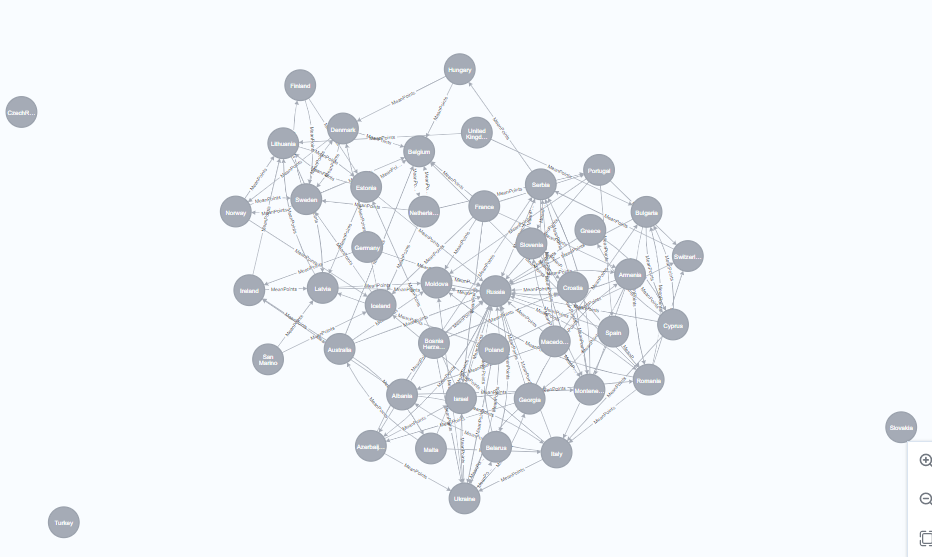](attachment:GraphMean.png)


### Community Detection using Louvain (now using Mean Votes)

First, we are storing the graph

In [153]:
query_string = '''
CALL gds.graph.project(  

'myGraph6',  

'Country',  

{  

MeanPoints: {  

orientation: 'UNDIRECTED'  

}  

}, 
 

{  

relationshipProperties: toFloat('Connection')  

}  

) 

 
'''
conn.query(query_string, db='coradb')


[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'MeanPoints': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'MeanPoints', 'properties': {}}} graphName='myGraph6' nodeCount=92 relationshipCount=2176 projectMillis=65>]

Storing the new communities in a dataframe

In [154]:
query_string = '''
CALL gds.louvain.stream('myGraph6')  

 
 

YIELD nodeId, communityId, intermediateCommunityIds  

 
 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds  

 
 

ORDER BY communityId ASC 
 
'''
conn.query(query_string, db='coradb')

group_unweighted_Mean = DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_unweighted_Mean

,name,communityId,intermediateCommunityIds
0,Switzerland,18,None
1,Estonia,18,None
2,San Marino,18,None
3,Lithuania,18,None
4,Latvia,18,None
...,...,...,...
87,Slovakia,44,None
88,CzechRepublic,67,None
89,Turkey,72,None
90,Austria,76,None
